A classical problem in operations management is inventory management. Here we manage to apply DRL method to the following inventory management problems: \\

Lost Sales Inventory Replenishment:  Consider the periodic-review inventory replenishment of a single item over an innite horizon. In
 the conventional lost sales model, inventory can be replenished at unit cost $c$ with lead time $l$. At
 the beginning of any period $t$, the order quantity, $q_t \geq 0$, must be decided knowing the last observed
 inventory on hand $I_{t-1}$. If $l = 0$, then the order is delivered immediately, otherwise the order at times $t-l$ arrived as $q_{t-l}$. A demand from the customer $d_t$ is then realized, and if the inventory is not enough excess demand will be lost. As a consequence, the next period on hand inventory evolves as $I_t = [I_{t-1} + q_{t-l} - d_t]^+$. \\
 To describe the system state, we use an $l+1$ dimension state vector $S_t = (I_{t-1}, Q_{t-1})$, where $Q_{t-1} = (q_{t-l}, q_{t-l+1}, \dots, q_{t-1})$. The action vector for the lost sales problem is one-dimensional consisting of the
 units ordered $a_t = (q_t)$. Cost at time $t$ is a combination of replenishment cost $cq_t$, holding cost $hI_t$ and lost sale cost $p[d_t - I_{t-1} - q_{t-1}]^+$:
 \begin{equation*}
c(S_t,a_t) = cq_t + hI_t + p[d_t - I_{t-1} - q_{t-1}]^+
 \end{equation*}
The value function starting from state $S_t$ with policy $\pi$ is defined as:
\begin{equation*}
V^{\pi}(S_t) = \sum\limits_{j=0}^{\infty} \gamma^j \mathrm{E}^{\pi}[c(S_{t+j}, a_{t+j})]
 \end{equation*}
 We assume $d_t$ follows Poisson distribution with rate $\lambda = 5$, and the ordering cost $c = 0$, the unit holding cost $h = 1$. Lead time varies from $l = 2,3,4$ and the lost sale cost $p = 4,9$. The discounting factor is set as $\gamma = 0.99$. \\

 Here the goal is to find a policy $\pi^{\ast}$ that minimize the discounting cost, due to the curse of dimensionality, the exact optimal policy is hard to achieve so we do not require you to compute the optimal gap. Instead, you should compute the value function for different policy and the training loss when you are using the DRL algorithms.

# 1.Simulate The System Dynamics
You should first simulate the system dynamics, and I suggest you to use a class to describe the process. Buffer size here refers to the length of your observation, for example, if the buffer size is $m$, you should store the next $m$ states $(S_t, \dots, S_{t+m-1})$ and actions $(a_t, \dots, a_{t+m-1}$to update your parameters, if you are using the temporal difference, the form should be:
\begin{equation*}
V^{\pi}(S_t, a_t) - (\gamma^m V^{\pi}(S_{t+m}, a_{t+m}) + \sum\limits_{p=0}^{m-1}\gamma^p c(S_{t+p}, a_{t+p}))
\end{equation*}
instead of:
\begin{equation*}
V^{\pi}(S_t, a_t) - (\gamma V^{\pi}(S_{t+p}, a_{t+p}) + c(S_{t}, a_{t}))
\end{equation*}
For each epoch we would like to simulate 100 conseutive buffers, and the state vector is denoted as $(S_{km}, \dots, S_{(k+1)m-1}), k = 1,\dots, 100$.   

In [ ]:
import numpy as np
class Lostsale(object):
  "Please provide your code here, your code should at least include the init function and step function which returns the next state and reward"
  "Your code should be adaptive the buffer size, here the buffer size is assumed to be 10"
  def __init__(self, buffer_size = 100, gamma = 0.99, p=4, l=2):
    self.state_dim = l+1
    self.n_action = 11
    self.discount = gamma
    self.p = p # variable
    self.buffer_size = buffer_size
    self.lead = l # variable
    self.ini_state = np.zeros(l+1)
    self.state=None
    self.buffer = Replaybuffer(capacity=buffer_size, n_step=1, gamma=gamma)
    self.reset()

  def step(self, state, action, demand):
    next_state = np.zeros(self.lead+1)
    next_state[0] = max(state[0] + state[1] - demand, 0)
    for i in range(self.lead-1):
      next_state[i+1] = state[i+2]
    next_state[-1] = action #next_state[0] = action
    cost = next_state[0] + self.p*max(0, demand - state[0] - state[1])
    rewards = -cost
    return next_state.copy(), rewards


  ### BEGIN HERE
  def reset(self):
        self.state = self.ini_state.copy()
        return self.state.copy()

  def sample_demand(self, lam=5.0):
        return np.random.poisson(lam)

  def env_step(self, action, demand=None):
        if demand is None:
            demand = self.sample_demand()
        transition = [self.state.copy(),action]
        next_state, reward = self.step(self.state, action, demand)
        self.state = next_state
        transition.extend([reward, next_state.copy()])
        self.buffer.push(transition)
        return next_state.copy(), reward



  ### END HERE

# 2.Create The Agents
You are required to use at least the following algorithms to obtain policies:


*   Deep-Q Learning: The core idea is to use a deep network to approximate the Q function, and the parameter update is implemented via using the temporal difference form as the loss function. A target network is also maintained to stabilize the training process. You can refer to https://arxiv.org/abs/1312.5602 for details.
*   Actor Critic Algorithm: The core idea is keep an Actor network for updating parameters policy and selecting action based on the policy. The critic network is used for approximating the value function. As a consequence, the loss function in actor critic should include both value loss and policy loss(for each buffer/periods):
\begin{equation*}
ValueLoss = \beta_V [V^{\pi}(S_t, a_t) - (\gamma^m V^{\pi}(S_{t+p}, a_{t+p}) + \sum\limits_{p=0}^{m-1}\gamma^p c(S_{t+p}, a_{t+p}))]^2
\end{equation*}
\begin{equation*}
PolicyLoss = (\sum\limits_{i=0}^{m-1}\log^{\pi_{\theta}}(A_{t+i}\vert S_{t+i}))(V^{\pi}(S_t, a_t) - (\gamma^m V^{\pi}(S_{t+p}, a_{t+p}) + \sum\limits_{p=0}^{m-1}\gamma^p c(S_{t+p}, a_{t+p})))
\end{equation*}

You can refer to https://proceedings.neurips.cc/paper/1999/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf for more details and https://arxiv.org/abs/1602.01783 if you want to use the Asynchronous Actor Critic Algorithms(A3C). Implementations of A2C and DQN can be referred to https://github.com/XinJingHao/DRL-Pytorch?tab=readme-ov-file.

Other candidates may include:


*   Soft Actor Critic: https://arxiv.org/abs/1801.01290
*   PPO: https://arxiv.org/abs/1707.06347
*   DDPG: https://proceedings.mlr.press/v32/silver14.pdf and https://arxiv.org/abs/1509.02971
*   ...





In [ ]:
import random, collections, copy
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.distributions import Categorical
import torch.nn.functional as F

## DQN, A2C
**DQN: action-value based, discrete actioin\
A2C: value based, dicrete/continuous action**


Tuning: learning rate, layers of network\
Tuning on DQN: declining epsilon\
Tuning on A2C: declining learning rate, entropy beta, clip gradient,

In [ ]:
class Replaybuffer(object):
  "The Replaybuffer is designed for you to store the history sample paths"
  "You can interact with the Replaybuffer to update your parameters"
  def __init__(self, capacity=100_000, n_step=1, gamma=0.99):
        self.buf = collections.deque(maxlen=capacity)
        self.n    = n_step
        self.g    = gamma
  def __repr__(self):
        return self.buf.__repr__()

  def push(self, traj):
        self.buf.append(traj)

  def sample(self, batch_size):
        start = random.randint(0, len(self.buf) - batch_size)
        batch = list(self.buf)[start:start+batch_size]
        return batch

  def __len__(self):
        return len(self.buf)

def mlp(in_dim, out_dim, hidden=(128, 128), act=nn.ReLU, out_act=None):
    layers, dim = [], in_dim
    for h in hidden:
        layers += [nn.Linear(dim, h), act()]
        dim = h
    layers += [nn.Linear(dim, out_dim)]
    if out_act: layers.append(out_act())
    return nn.Sequential(*layers)


class QNetwork(nn.Module):
  "The deep network for training your model"
  def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = mlp(obs_dim, act_dim)
  def forward(self, x):
        return self.net(x)

class Policy(nn.Module):
  "Policy network if you are using the policy-based algorithms"
  ### BEGIN HERE
  def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = mlp(obs_dim, act_dim)
        self.softmax = nn.Softmax(dim=-1)
  def forward(self, x):
    x = self.net(x)
    return self.softmax(x)
  ### END HERE

class Value(nn.Module):
  def __init__(self, obs_dim):
        super().__init__()
        self.net = mlp(obs_dim, 1)
  def forward(self, x):
        return self.net(x)

class ContinuousPolicy(nn.Module):
  def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = mlp(obs_dim, act_dim)

def policy_entropy(obs,actor):
    logits = actor(torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0))
    dist = torch.distributions.Categorical(logits=logits)
    return dist.entropy().item()


In [ ]:
class AC_agent:
    def __init__(self, obs_dim, act_dim, n_step, gamma, lr_a=1e-3, lr_c=1e-3):
        self.n, self.g = n_step, gamma
        self.actor = Policy(obs_dim, act_dim).to(device)
        self.critic = Value(obs_dim).to(device)
        self.opt_a = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.opt_c = optim.Adam(self.critic.parameters(), lr=lr_c)
        self.lr_sch_a = optim.lr_scheduler.StepLR(self.opt_a, step_size=500, gamma=0.1)
        self.lr_sch_c = optim.lr_scheduler.StepLR(self.opt_c, step_size=500, gamma=0.1)

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, buf):
        curr_state = buf[0][0]
        next_state_n = buf[-1][-1]
        rewards = [traj[2] for traj in buf]
        cum_r = sum((self.g ** p) * r for p, r in enumerate(rewards))
        v_curr = self.critic(torch.tensor(curr_state,dtype=torch.float32).to(device))
        with torch.no_grad():
          v_next = self.critic(torch.tensor(next_state_n,dtype=torch.float32).to(device))
        target = cum_r + (self.g ** self.n) * v_next
        TD_error = target - v_curr
        critic_loss = TD_error.pow(2)/2

        states = torch.tensor(np.array([traj[0] for traj in buf]),dtype=torch.float).to(device)
        actions = torch.tensor(np.array([traj[1] for traj in buf])).to(device).unsqueeze(1)
        log_probs = torch.log(self.actor(states).gather(1, actions)+1e-8)
        actor_loss = torch.mean(-log_probs * TD_error.detach())

        self.opt_a.zero_grad()
        self.opt_c.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.opt_a.step(); self.lr_sch_a.step()
        self.opt_c.step(); self.lr_sch_c.step()
        return actor_loss.item() + critic_loss.item()

class DQN_agent(object):
  "Agent for the Deep Q Learning"
  "Your code should include the training process(update parameters) and action selection"
  def __init__(self, obs_dim, act_dim, n_step, gamma, lr=1e-3):
        self.n, self.g = n_step, gamma
        self.q = QNetwork(obs_dim, act_dim).to(device)
        self.q_tgt = copy.deepcopy(self.q).eval()
        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.act_dim = act_dim
        self.eps, self.eps_end, self.eps_dec = 1.0, 0.05, 500 # decreasing exploration rate

  def act(self, obs):
        if random.random() < self._epsilon():
            return random.randrange(self.act_dim)
        with torch.no_grad():
            q = self.q(torch.tensor(obs,dtype=torch.float32,device=device))
        return int(q.argmax().item())

  def _epsilon(self):
        self.eps = max(self.eps_end, self.eps - (1 - self.eps_end) / self.eps_dec)
        return self.eps

  def learn(self, buf):
        curr_state = buf[0][0]
        curr_action = buf[0][1]
        next_state_n = buf[-1][-1]
        rewards = [traj[2] for traj in buf]
        cum_r = sum((self.g ** p) * r for p, r in enumerate(rewards))
        q_curr = self.q(torch.tensor(curr_state,dtype=torch.float32).to(device))[curr_action]
        with torch.no_grad():
            q_next = self.q_tgt(torch.tensor(next_state_n,dtype=torch.float32).to(device)).max().item()
        target = cum_r + (self.g ** self.n) * q_next
        TD_error = target - q_curr
        loss = TD_error.pow(2)/2
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        return loss.item()
  def update_tgt(self):
        self.q_tgt.load_state_dict(self.q.state_dict())

## PPO: value-based, type of actor-critic

In [ ]:
class PPOAgent:
    def __init__(self, obs_dim, act_dim, n_step, gamma, lmbda=0.95, lr_a=3e-4, lr_c=3e-3):
        self.n, self.g, self.l = n_step, gamma, lmbda
        self.actor = Policy(obs_dim, act_dim).to(device)
        self.critic = Value(obs_dim).to(device)
        self.opt_a = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.opt_c = optim.Adam(self.critic.parameters(), lr=lr_c)
        self.lr_sch_a = optim.lr_scheduler.StepLR(self.opt_a, step_size=500, gamma=0.1)
        self.lr_sch_c = optim.lr_scheduler.StepLR(self.opt_c, step_size=500, gamma=0.1)
        self.K_epochs = 10
        self.eps_clip = 0.2

    def act(self, obs):
          obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
          logits = self.actor(obs)
          dist = torch.distributions.Categorical(logits=logits)
          return int(dist.sample().item())

    def update(self, buf):
        states = torch.tensor([traj[0] for traj in buf],dtype=torch.float32).to(device)
        actions = torch.tensor([traj[1] for traj in buf]).to(device).unsqueeze(1)
        rewards = torch.tensor([traj[2] for traj in buf],dtype=torch.float32).to(device)
        nextstates = torch.tensor([traj[-1] for traj in buf],dtype=torch.float32).to(device)

        td_target = rewards + self.g * self.critic(nextstates).squeeze(-1)
        td_delta = td_target - self.critic(states).squeeze(-1)
        advantage = self.compute_advantage(td_delta.cpu()).to(device)
        old_log_probs = torch.log(self.actor(states).gather(1,actions)+1e-8).detach()

        for _ in range(self.K_epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions)+1e-8)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip,1 + self.eps_clip) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.opt_a.zero_grad()
            self.opt_c.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.opt_a.step(); self.lr_sch_a.step()
            self.opt_c.step(); self.lr_sch_c.step()
        return (actor_loss + critic_loss).item()

    def compute_advantage(self, td_delta):
        advantage_list = []
        advantage = 0.0
        for delta in reversed(td_delta.squeeze().tolist()):
            advantage = self.g * self.l * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float32, device=device)


## SAC: maximum entropy

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F

class SACAgent:
    def __init__(self, obs_dim, act_dim, n_step, gamma, target_entropy, tau, lr_a=3e-4, lr_c=3e-3, lr_alpha=1e-2):
        self.n, self.g = n_step, gamma
        self.target_entropy = target_entropy
        self.tau = tau
        self.actor = Policy(obs_dim, act_dim).to(device)
        self.critic1 = QNetwork(obs_dim, act_dim).to(device)
        self.critic2 = QNetwork(obs_dim, act_dim).to(device)
        self.critic1_tgt = copy.deepcopy(self.critic1).eval()
        self.critic2_tgt = copy.deepcopy(self.critic2).eval()
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float, device=device)
        self.log_alpha.requires_grad = True

        self.opt_a = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.opt_c1 = optim.Adam(self.critic1.parameters(), lr=lr_c)
        self.opt_c2 = optim.Adam(self.critic2.parameters(), lr=lr_c)
        self.lr_sch_a = optim.lr_scheduler.StepLR(self.opt_a, step_size=500, gamma=0.1)
        self.lr_sch_c1 = optim.lr_scheduler.StepLR(self.opt_c1, step_size=500, gamma=0.1)
        self.lr_sch_c2 = optim.lr_scheduler.StepLR(self.opt_c2, step_size=500, gamma=0.1)
        self.log_alpha_optimizer = optim.Adam([self.log_alpha],lr=lr_alpha)

    def act(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        logits = self.actor(obs)
        dist = torch.distributions.Categorical(logits=logits)
        return int(dist.sample().item())

    def calc_target(self, rewards, next_state_n):
        next_probs = self.actor(next_state_n)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs)
        q1_value = self.critic1_tgt(next_state_n)
        q2_value = self.critic2_tgt(next_state_n)
        min_qvalue = next_probs * torch.min(q1_value, q2_value)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        discounted_rewards = torch.sum(torch.tensor([self.g**i*reward.item() for i, reward in enumerate(rewards[:-1])],device=device))
        td_target = discounted_rewards + self.g**self.n * next_value
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, buf):
        states = torch.tensor([traj[0] for traj in buf],dtype=torch.float32).to(device)
        actions = torch.tensor([traj[1] for traj in buf]).to(device).unsqueeze(1)
        rewards = torch.tensor([traj[2] for traj in buf],dtype=torch.float32).to(device)
        next_states = torch.tensor([traj[-1] for traj in buf],dtype=torch.float32).to(device)
        next_state_n = next_states[-1]
        td_target = self.calc_target(rewards, next_state_n)
        critic_1_q_values = self.critic1(states)
        critic_1_loss = torch.mean(
            F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic2(states)
        critic_2_loss = torch.mean(
            F.mse_loss(critic_2_q_values, td_target.detach()))
        self.opt_c1.zero_grad()
        critic_1_loss.backward()
        self.opt_c1.step(); self.lr_sch_c1.step()
        self.opt_c2.zero_grad()
        critic_2_loss.backward()
        self.opt_c2.step(); self.lr_sch_c2.step()

        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        q1_value = self.critic1(states)
        q2_value = self.critic2(states)
        min_qvalue = probs * torch.min(q1_value, q2_value)
        actor_loss = -torch.mean(self.log_alpha.exp() * entropy + min_qvalue)
        self.opt_a.zero_grad()
        actor_loss.backward()
        self.opt_a.step(); self.lr_sch_a.step()

        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic1, self.critic1_tgt)
        self.soft_update(self.critic2, self.critic2_tgt)
        return (actor_loss + critic_1_loss + critic_2_loss).item()

# 3.Training Step Design

In [ ]:
from tqdm import tqdm
def train_dqn(env, agent, epochs=200, num_steps=100, buffer_sample_size=10, tgt_update_step=10, learn_step=5):
    value_curve, loss_curve, epoch_loss_curve = [], [], []
    b = buffer_sample_size
    c = tgt_update_step
    n = learn_step

    # Check agent's model(s) on GPU
    assert next(agent.q.parameters()).is_cuda, "Agent's Q network is not on GPU!"
    assert next(agent.q_tgt.parameters()).is_cuda, "Agent's target Q network is not on GPU!"

    for ep in range(epochs):
        obs = env.reset()
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32, device=device)
        else:
            obs = obs.to(device)
        assert obs.device.type == "cuda", "Observation tensor is not on GPU!"

        ep_ret, discount = 0.0, 1.0
        epoch_loss = []

        for step in range(num_steps):
            loss = None

            if step % c == 0:
                agent.update_tgt()

            action = agent.act(obs)
            next_obs, reward = env.env_step(action)

            if isinstance(next_obs, np.ndarray):
                next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)
            else:
                next_obs = next_obs.to(device)
            assert next_obs.device.type == "cuda", "Next observation tensor is not on GPU!"

            ep_ret += discount * reward
            discount *= env.discount

            if step >= b and step % n == 0:
                batch = env.buffer.sample(b)
                loss = agent.learn(batch)
                epoch_loss.append(loss)

            obs = next_obs
            if loss is not None:
                loss_curve.append(loss)

        value_curve.append(ep_ret)
        ep_loss_scalar = np.mean(epoch_loss)
        epoch_loss_curve.append(ep_loss_scalar)
        # print(f"EP {ep:03d} | cost {-ep_ret:9.1f} | loss {ep_loss_scalar:.4f}")

    return value_curve, loss_curve, epoch_loss_curve


def train_actor_critic(env, agent, epochs=200, num_steps=100, buffer_sample_size=10, learn_step=5):
    value_curve, loss_curve, epoch_loss_curve = [], [], []
    entropy_value = []
    b = buffer_sample_size
    n = learn_step

    # Check model is on GPU
    assert next(agent.actor.parameters()).is_cuda, "Agent's actor is not on GPU!"
    # assert next(agent.critic.parameters()).is_cuda, "Agent's critic is not on GPU!"

    for ep in range(epochs):
        obs = env.reset()
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float32, device=device)
        else:
            obs = obs.to(device)
        assert obs.device.type == "cuda", "Observation tensor is not on GPU!"

        ep_ret, discount = 0.0, 1.0
        epoch_loss = []
        epoch_entropy = []

        for step in range(num_steps):
            loss = None

            # Act and ensure device consistency
            action = agent.act(obs)
            next_obs, reward = env.env_step(action)

            if isinstance(next_obs, np.ndarray):
                next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)
            else:
                next_obs = next_obs.to(device)
            assert next_obs.device.type == "cuda", "Next observation tensor is not on GPU!"

            ep_ret += discount * reward
            discount *= env.discount

            # Learning step
            if step >= b and step % n == 0:
                sample = env.buffer.sample(b)
                loss = agent.update(sample)
                epoch_loss.append(loss)

            obs = next_obs
            if loss is not None:
                loss_curve.append(loss)

            entropy = policy_entropy(obs, agent.actor)
            epoch_entropy.append(entropy)

        ep_entropy_scalar = np.mean(epoch_entropy)
        entropy_value.append(ep_entropy_scalar)
        ep_loss_scalar = np.mean(epoch_loss)
        epoch_loss_curve.append(ep_loss_scalar)
        value_curve.append(ep_ret)

        # print(f"EP {ep:03d} | cost {-ep_ret:9.1f} | loss {ep_loss_scalar:.4f}")

    return value_curve, loss_curve, epoch_loss_curve, entropy_value


def make_env(p,l):
    return Lostsale(p=p, l=l)

def base_policy(obs, S=20, max_order=10, lead=2):
    I = obs[0]
    pipeline = sum(obs[1:])
    action = max(0, S - (I + pipeline))
    return min(action, max_order)
def train_base(env, policy_func, epochs=200, buffers_per_epoch=100):
    value_curve = []
    for ep in range(epochs):
        obs = env.reset()
        ep_ret, discount = 0.0, 1.0
        for _ in range(buffers_per_epoch * env.buffer_size):
            #discount = 1.0
            a = policy_func(obs)
            obs, r = env.env_step(a)
            ep_ret += discount * r
            discount *= env.discount
        value_curve.append(ep_ret)
        print(f"[BASE] EP {ep:03d} | cost {-ep_ret:9.1f}")
    return value_curve

In [ ]:
# p=4,9
# l=2,3,4
p,l = 4,2
env_dqn = make_env(p,l)
dqn_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/dqn_model.pth')
dqn = DQN_agent(obs_dim=env_dqn.state_dim, act_dim=env_dqn.n_action, n_step=env_dqn.buffer_size, gamma=env_dqn.discount)
dqn.q.load_state_dict(dqn_dict['model_state_dict'])

v_dqn, l_dqn, epoch_l_dqn = train_dqn(env_dqn, dqn, num_steps=100)

EP 000 | cost     637.9 | loss 2121.8357
EP 001 | cost     600.6 | loss 904.3491
EP 002 | cost     544.0 | loss 1232.0197
EP 003 | cost     436.7 | loss 276.9945
EP 004 | cost     463.6 | loss 198.3927
EP 005 | cost     533.3 | loss 233.0910
EP 006 | cost     532.5 | loss 491.0210
EP 007 | cost     398.8 | loss 283.1060
EP 008 | cost    1066.1 | loss 3836.8088
EP 009 | cost     411.7 | loss 959.0101
EP 010 | cost     438.4 | loss 515.2469
EP 011 | cost     441.1 | loss 189.8180
EP 012 | cost     392.3 | loss 595.7288
EP 013 | cost     424.3 | loss 424.4967
EP 014 | cost     302.9 | loss 333.1881
EP 015 | cost     439.8 | loss 365.8984
EP 016 | cost     384.2 | loss 86.8029
EP 017 | cost     370.8 | loss 167.7047
EP 018 | cost     391.7 | loss 173.1854
EP 019 | cost     342.9 | loss 170.9394
EP 020 | cost     469.1 | loss 571.0160
EP 021 | cost     622.7 | loss 606.1970
EP 022 | cost     519.6 | loss 311.8996
EP 023 | cost     703.2 | loss 566.4932
EP 024 | cost     567.4 | loss 253.939

In [ ]:
p,l=4,2
env_ac = make_env(p,l)
a2c_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/a2c_model.pth')
ac = AC_agent(obs_dim=env_ac.state_dim, act_dim=env_ac.n_action, n_step=env_ac.buffer_size, gamma=env_ac.discount)
ac.actor.load_state_dict(a2c_dict['actor_state_dict'])
v_ac, l_ac, epoch_l_ac, ent_ac = train_actor_critic(env_ac, ac, num_steps=100)

EP 000 | cost     388.6 | loss 1483.7465
EP 001 | cost     398.1 | loss 1430.4404
EP 002 | cost     397.7 | loss 1144.6452
EP 003 | cost     300.1 | loss 363.5847
EP 004 | cost     416.1 | loss 414.6385
EP 005 | cost     383.2 | loss 559.2624
EP 006 | cost     389.1 | loss 250.0680
EP 007 | cost     360.8 | loss 203.4679
EP 008 | cost     418.5 | loss 258.1451
EP 009 | cost     321.7 | loss 135.2260
EP 010 | cost     397.2 | loss 288.3087
EP 011 | cost     406.7 | loss 109.4255
EP 012 | cost     368.9 | loss 151.3327
EP 013 | cost     332.9 | loss 321.6065
EP 014 | cost     443.0 | loss 250.9314
EP 015 | cost     327.4 | loss 209.8956
EP 016 | cost     344.3 | loss 144.1531
EP 017 | cost     360.5 | loss 276.5895
EP 018 | cost     318.3 | loss 52.7097
EP 019 | cost     382.3 | loss 418.8691
EP 020 | cost     319.6 | loss 209.9330
EP 021 | cost     336.5 | loss 438.3115
EP 022 | cost     300.1 | loss 267.4510
EP 023 | cost     383.5 | loss 430.4978
EP 024 | cost     459.0 | loss 489.717

In [ ]:
p,l = 4,2
env_ppo = make_env(p,l)
ppo_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/ppo_model.pth')
ppo = PPOAgent(obs_dim=env_ac.state_dim, act_dim=env_ac.n_action, n_step=env_ac.buffer_size, gamma=env_ac.discount)
ppo.actor.load_state_dict(ppo_dict['actor_state_dict'])
v_ppo, l_ppo, epoch_l_ppo, ent_ppo = train_actor_critic(env_ppo, ppo, num_steps=100)

<ipython-input-70-48f13f12b065>:36: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))


EP 000 | cost    1385.3 | loss 1492.3429
EP 001 | cost     556.7 | loss 4160.9647
EP 002 | cost     619.3 | loss 789.3943
EP 003 | cost     657.7 | loss 700.3841
EP 004 | cost    1013.9 | loss 1133.8926
EP 005 | cost     775.9 | loss 1355.3288
EP 006 | cost     565.3 | loss 791.1418
EP 007 | cost     447.2 | loss 609.9923
EP 008 | cost     530.0 | loss 394.3195
EP 009 | cost     576.3 | loss 701.5602
EP 010 | cost     458.6 | loss 677.5470
EP 011 | cost     712.3 | loss 603.4884
EP 012 | cost     748.3 | loss 602.3807
EP 013 | cost     527.6 | loss 2198.5639
EP 014 | cost     846.6 | loss 1161.5892
EP 015 | cost     545.7 | loss 645.0839
EP 016 | cost     579.3 | loss 644.5648
EP 017 | cost     520.0 | loss 476.1010
EP 018 | cost     485.4 | loss 502.9250
EP 019 | cost     719.5 | loss 622.8273
EP 020 | cost     552.2 | loss 1284.6410
EP 021 | cost     665.2 | loss 409.6401
EP 022 | cost    1210.3 | loss 1160.9260
EP 023 | cost     655.4 | loss 923.7851
EP 024 | cost     693.9 | loss 5

In [ ]:
best_rewards, best_params, best_agent = ModelTune(p, l, 'sac')

lr_c:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-6-2c9dddc57e41>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-3-a559de708608>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = actor(torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0))
<ipython-input-6-2c9dddc57e41>:55: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([10, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(critic_1_q_values, td_target.detach()))
<ipython-input-6-2c9dddc57e41>:58:

In [ ]:
best_params

{'lr_a': 0.001,
 'lr_c': 0.0001,
 'lr_alpha': 0.001,
 'target_entropy': -1,
 'tau': 0.005}

In [ ]:
p,l = 4,2
env_sac = make_env(p,l)
sac_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/sac_model.pth')
sac = SACAgent(obs_dim=env_sac.lead+1, act_dim=11, n_step=env_sac.buffer_size, gamma=env_sac.discount, target_entropy=-1, tau=0.005,
               lr_a=1e-3,lr_c=1e-4,lr_alpha=1e-3)
sac.actor.load_state_dict(sac_dict['actor_state_dict'])
v_sac, l_sac, epoch_l_sac, ent_sac = train_actor_critic(env_sac, sac)

<ipython-input-6-2c9dddc57e41>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
<ipython-input-3-a559de708608>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = actor(torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0))
<ipython-input-6-2c9dddc57e41>:55: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([10, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(critic_1_q_values, td_target.detach()))
<ipython-input-6-2c9dddc57e41>:58: UserWarning: Using a target size (torch.Si

EP 000 | cost     559.7 | loss 8348.9713
EP 001 | cost    1383.1 | loss 41680.4743
EP 002 | cost    1879.5 | loss 242018.6732
EP 003 | cost    1341.4 | loss 121457.4149
EP 004 | cost     688.7 | loss 89345.0422
EP 005 | cost    1539.9 | loss 77754.4824
EP 006 | cost    2548.8 | loss 187051.7272
EP 007 | cost    1996.6 | loss 379149.5582
EP 008 | cost    4099.0 | loss 470053.0775
EP 009 | cost    2151.1 | loss 466238.2859
EP 010 | cost    1317.6 | loss 178042.1415
EP 011 | cost    1496.1 | loss 72639.8317
EP 012 | cost     590.4 | loss 42764.5814
EP 013 | cost    1202.7 | loss 20400.1407
EP 014 | cost    1372.0 | loss 110541.7389
EP 015 | cost    2401.2 | loss 91962.1228
EP 016 | cost    1334.0 | loss 283593.9477
EP 017 | cost    1929.9 | loss 88181.6264
EP 018 | cost    1257.7 | loss 139672.5752
EP 019 | cost    2710.5 | loss 106405.0153
EP 020 | cost    2396.3 | loss 264522.7533
EP 021 | cost    1959.0 | loss 131698.3090
EP 022 | cost    1018.2 | loss 109665.3237
EP 023 | cost    1225

In [ ]:
# BASELINE
env_base = make_env(4,2)
v_base = train_base(env_base, base_policy)

[BASE] EP 000 | cost     577.7
[BASE] EP 001 | cost     590.5
[BASE] EP 002 | cost     613.4
[BASE] EP 003 | cost     608.6
[BASE] EP 004 | cost     650.9
[BASE] EP 005 | cost     578.7
[BASE] EP 006 | cost     654.8
[BASE] EP 007 | cost     625.4
[BASE] EP 008 | cost     580.2
[BASE] EP 009 | cost     619.2
[BASE] EP 010 | cost     635.8
[BASE] EP 011 | cost     570.1
[BASE] EP 012 | cost     648.1
[BASE] EP 013 | cost     633.8
[BASE] EP 014 | cost     655.1
[BASE] EP 015 | cost     663.9
[BASE] EP 016 | cost     611.2
[BASE] EP 017 | cost     590.7
[BASE] EP 018 | cost     601.1
[BASE] EP 019 | cost     617.5
[BASE] EP 020 | cost     660.4
[BASE] EP 021 | cost     605.9
[BASE] EP 022 | cost     709.5
[BASE] EP 023 | cost     636.5
[BASE] EP 024 | cost     670.3
[BASE] EP 025 | cost     581.6
[BASE] EP 026 | cost     620.9
[BASE] EP 027 | cost     611.8
[BASE] EP 028 | cost     689.7
[BASE] EP 029 | cost     578.1
[BASE] EP 030 | cost     605.0
[BASE] EP 031 | cost     730.3
[BASE] E

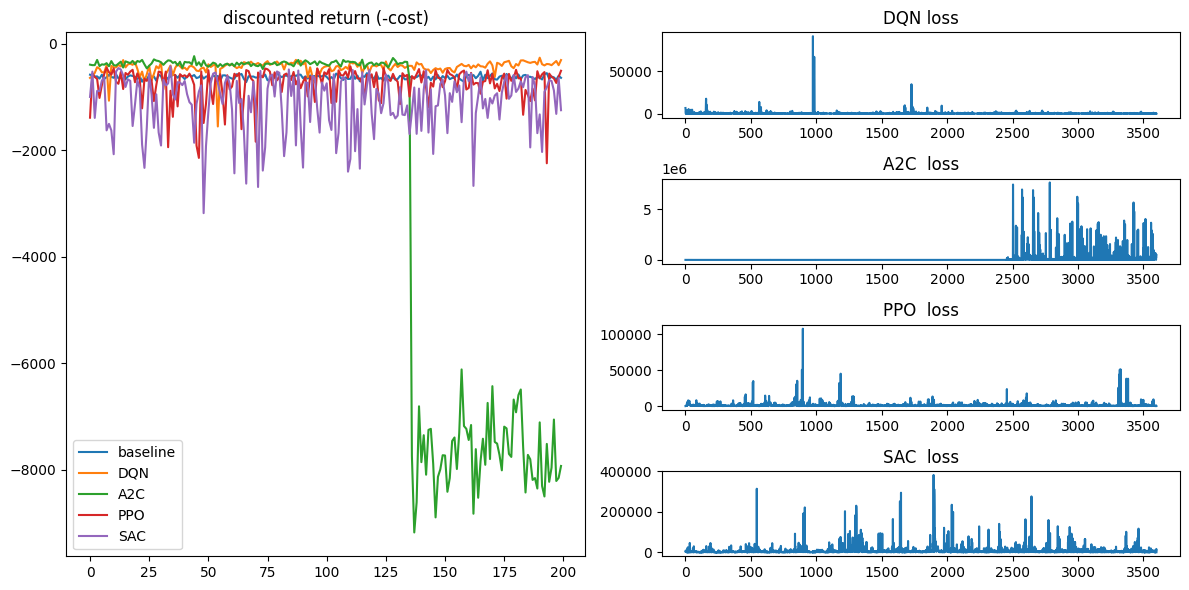

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(v_base, label='baseline')
plt.plot(v_dqn , label='DQN')
plt.plot(v_ac  , label='A2C')
plt.plot(v_ppo , label='PPO')
plt.plot(v_sac , label='SAC')
plt.title('discounted return (-cost)'); plt.legend()
plt.subplot(4,2,2); plt.plot(l_dqn); plt.title('DQN loss')
plt.subplot(4,2,4); plt.plot(l_ac ); plt.title('A2C  loss')
plt.subplot(4,2,6); plt.plot(l_ppo ); plt.title('PPO  loss')
plt.subplot(4,2,8); plt.plot(l_sac ); plt.title('SAC  loss')

plt.tight_layout(); plt.show()

**Note on A2C:** when the learning rate is relatively large, then the gradient descent on policy net would make the policy far from a right place, and therefore A2C is not a stable method. To solve this problem, **Trust Region Policy Optimization (TRPO) and Proximal Policy Optimization (PPO)** limit the difference between the current policy and the next policy at each step.

# 4.Experiments on varying price and lead time

In [ ]:
import os
def run_experiment(p, l,
          epochs=100, num_steps=100,
          buffer_sample_size=10,
          tgt_update_step=10, learn_step=5):
    env_dqn  = make_env(p, l)
    env_ac   = make_env(p, l)
    env_base = make_env(p, l)

    dqn = DQN_agent(obs_dim=env_dqn.state_dim,
                    act_dim=env_dqn.n_action,
                    n_step=env_dqn.buffer_size,
                    gamma=env_dqn.discount)

    ac  = AC_agent(obs_dim=env_ac.state_dim,
                   act_dim=env_ac.n_action,
                   n_step=env_ac.buffer_size,
                   gamma=env_ac.discount)


    v_dqn, l_dqn, epoch_l_dqn = train_dqn(
        env_dqn, dqn,
        epochs=epochs, num_steps=num_steps,
        buffer_sample_size=buffer_sample_size,
        tgt_update_step=tgt_update_step,
        learn_step=learn_step
    )


    v_ac,  l_ac, epoch_l_ac, ent_ac  = train_actor_critic(
        env_ac, ac,
        epochs=epochs, num_steps=num_steps,
        buffer_sample_size=buffer_sample_size,
        learn_step=learn_step
    )


    v_base = train_base(
        env_base, base_policy,
        epochs=epochs,
        buffers_per_epoch=num_steps
    )

    model_dir = f"models/p_{p}_l_{l}"  # Create a directory for each (p, l) combination
    os.makedirs(model_dir, exist_ok=True)

    # Save DQN model
    torch.save({
        'model_state_dict': dqn.q.state_dict(),
        'optimizer_state_dict': dqn.opt.state_dict(),
    }, os.path.join(model_dir, "dqn_model.pth"))

    # Save Actor-Critic models and optimizers
    torch.save({
        'actor_state_dict': ac.actor.state_dict(),
        'critic_state_dict': ac.critic.state_dict(),
        'actor_optimizer_state_dict': ac.opt_a.state_dict(),
        'critic_optimizer_state_dict': ac.opt_c.state_dict(),
    }, os.path.join(model_dir, "a2c_model.pth"))

    return v_base, v_dqn, v_ac, l_dqn, l_ac, epoch_l_dqn, epoch_l_ac


EP 000 | cost    2247.0 | loss 39810.3639
EP 001 | cost    2240.6 | loss 94803.9150
EP 002 | cost    1085.0 | loss 64209.2699
EP 003 | cost     580.2 | loss 9700.6809
EP 004 | cost     745.1 | loss 6772.0373
EP 005 | cost     962.4 | loss 7910.0646
EP 006 | cost     829.6 | loss 15156.1492
EP 007 | cost     954.7 | loss 8116.4927
EP 008 | cost    1654.8 | loss 18090.0825
EP 009 | cost    1280.2 | loss 35950.8823
EP 010 | cost    1510.6 | loss 19600.9351
EP 011 | cost     851.6 | loss 7519.7549
EP 012 | cost     450.2 | loss 1717.2441
EP 013 | cost    1645.8 | loss 2849.4846
EP 014 | cost    1281.4 | loss 7693.3036
EP 015 | cost    1421.1 | loss 7170.5332
EP 016 | cost     947.6 | loss 1412.9111
EP 017 | cost     953.6 | loss 1398.5241
EP 018 | cost     714.5 | loss 3069.7417
EP 019 | cost     864.2 | loss 914.5444
EP 020 | cost    1276.1 | loss 4587.8042
EP 021 | cost     519.0 | loss 2981.2794
EP 022 | cost     796.5 | loss 2149.9450
EP 023 | cost    1315.1 | loss 3159.4955
EP 024 | c

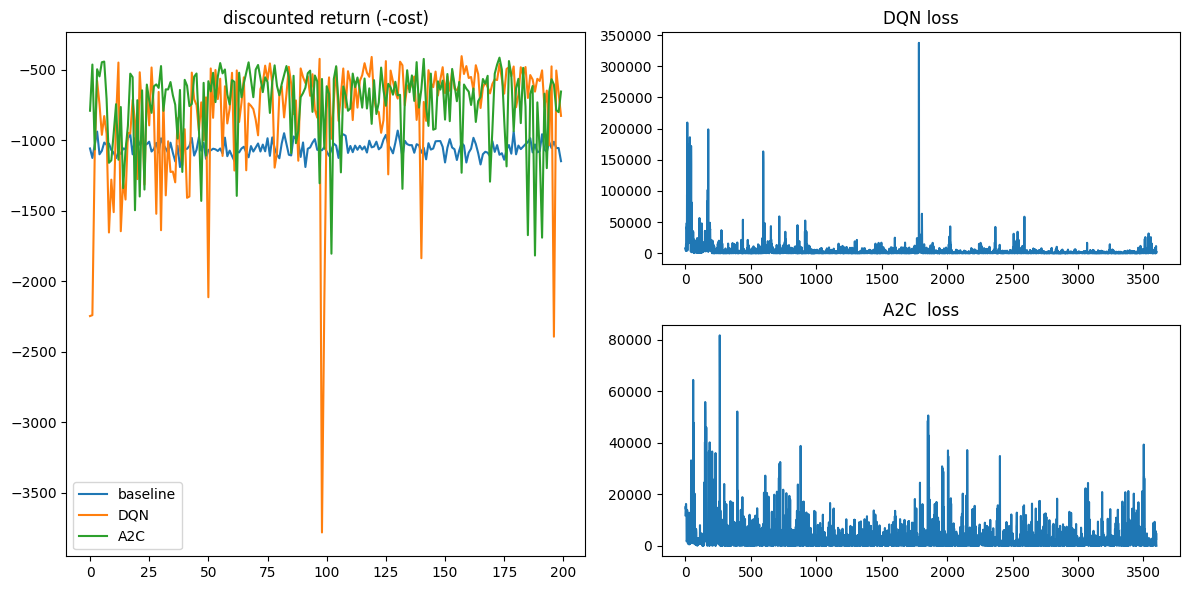

In [ ]:
v_base, v_dqn, v_ac, l_dqn, l_ac, epoch_l_dqn, epoch_l_ac = run_experiment(4, 2, epochs=200)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(v_base, label='baseline')
plt.plot(v_dqn , label='DQN')
plt.plot(v_ac  , label='A2C')
plt.title('discounted return (-cost)'); plt.legend()
plt.subplot(2,2,2); plt.plot(l_dqn); plt.title('DQN loss')
plt.subplot(2,2,4); plt.plot(l_ac ); plt.title('A2C  loss')
plt.tight_layout(); plt.show()

In [ ]:
param_grid = [(4, 2),\
        (4, 3),\
        (4, 4),\
        (9, 2),\
        (9, 3),\
        (9, 4)]


results = {}
for (p, l) in param_grid:
    print(f"Training for p={p}, l={l}")
    results[(p, l)] = run_experiment(p, l, epochs=200, num_steps=100)

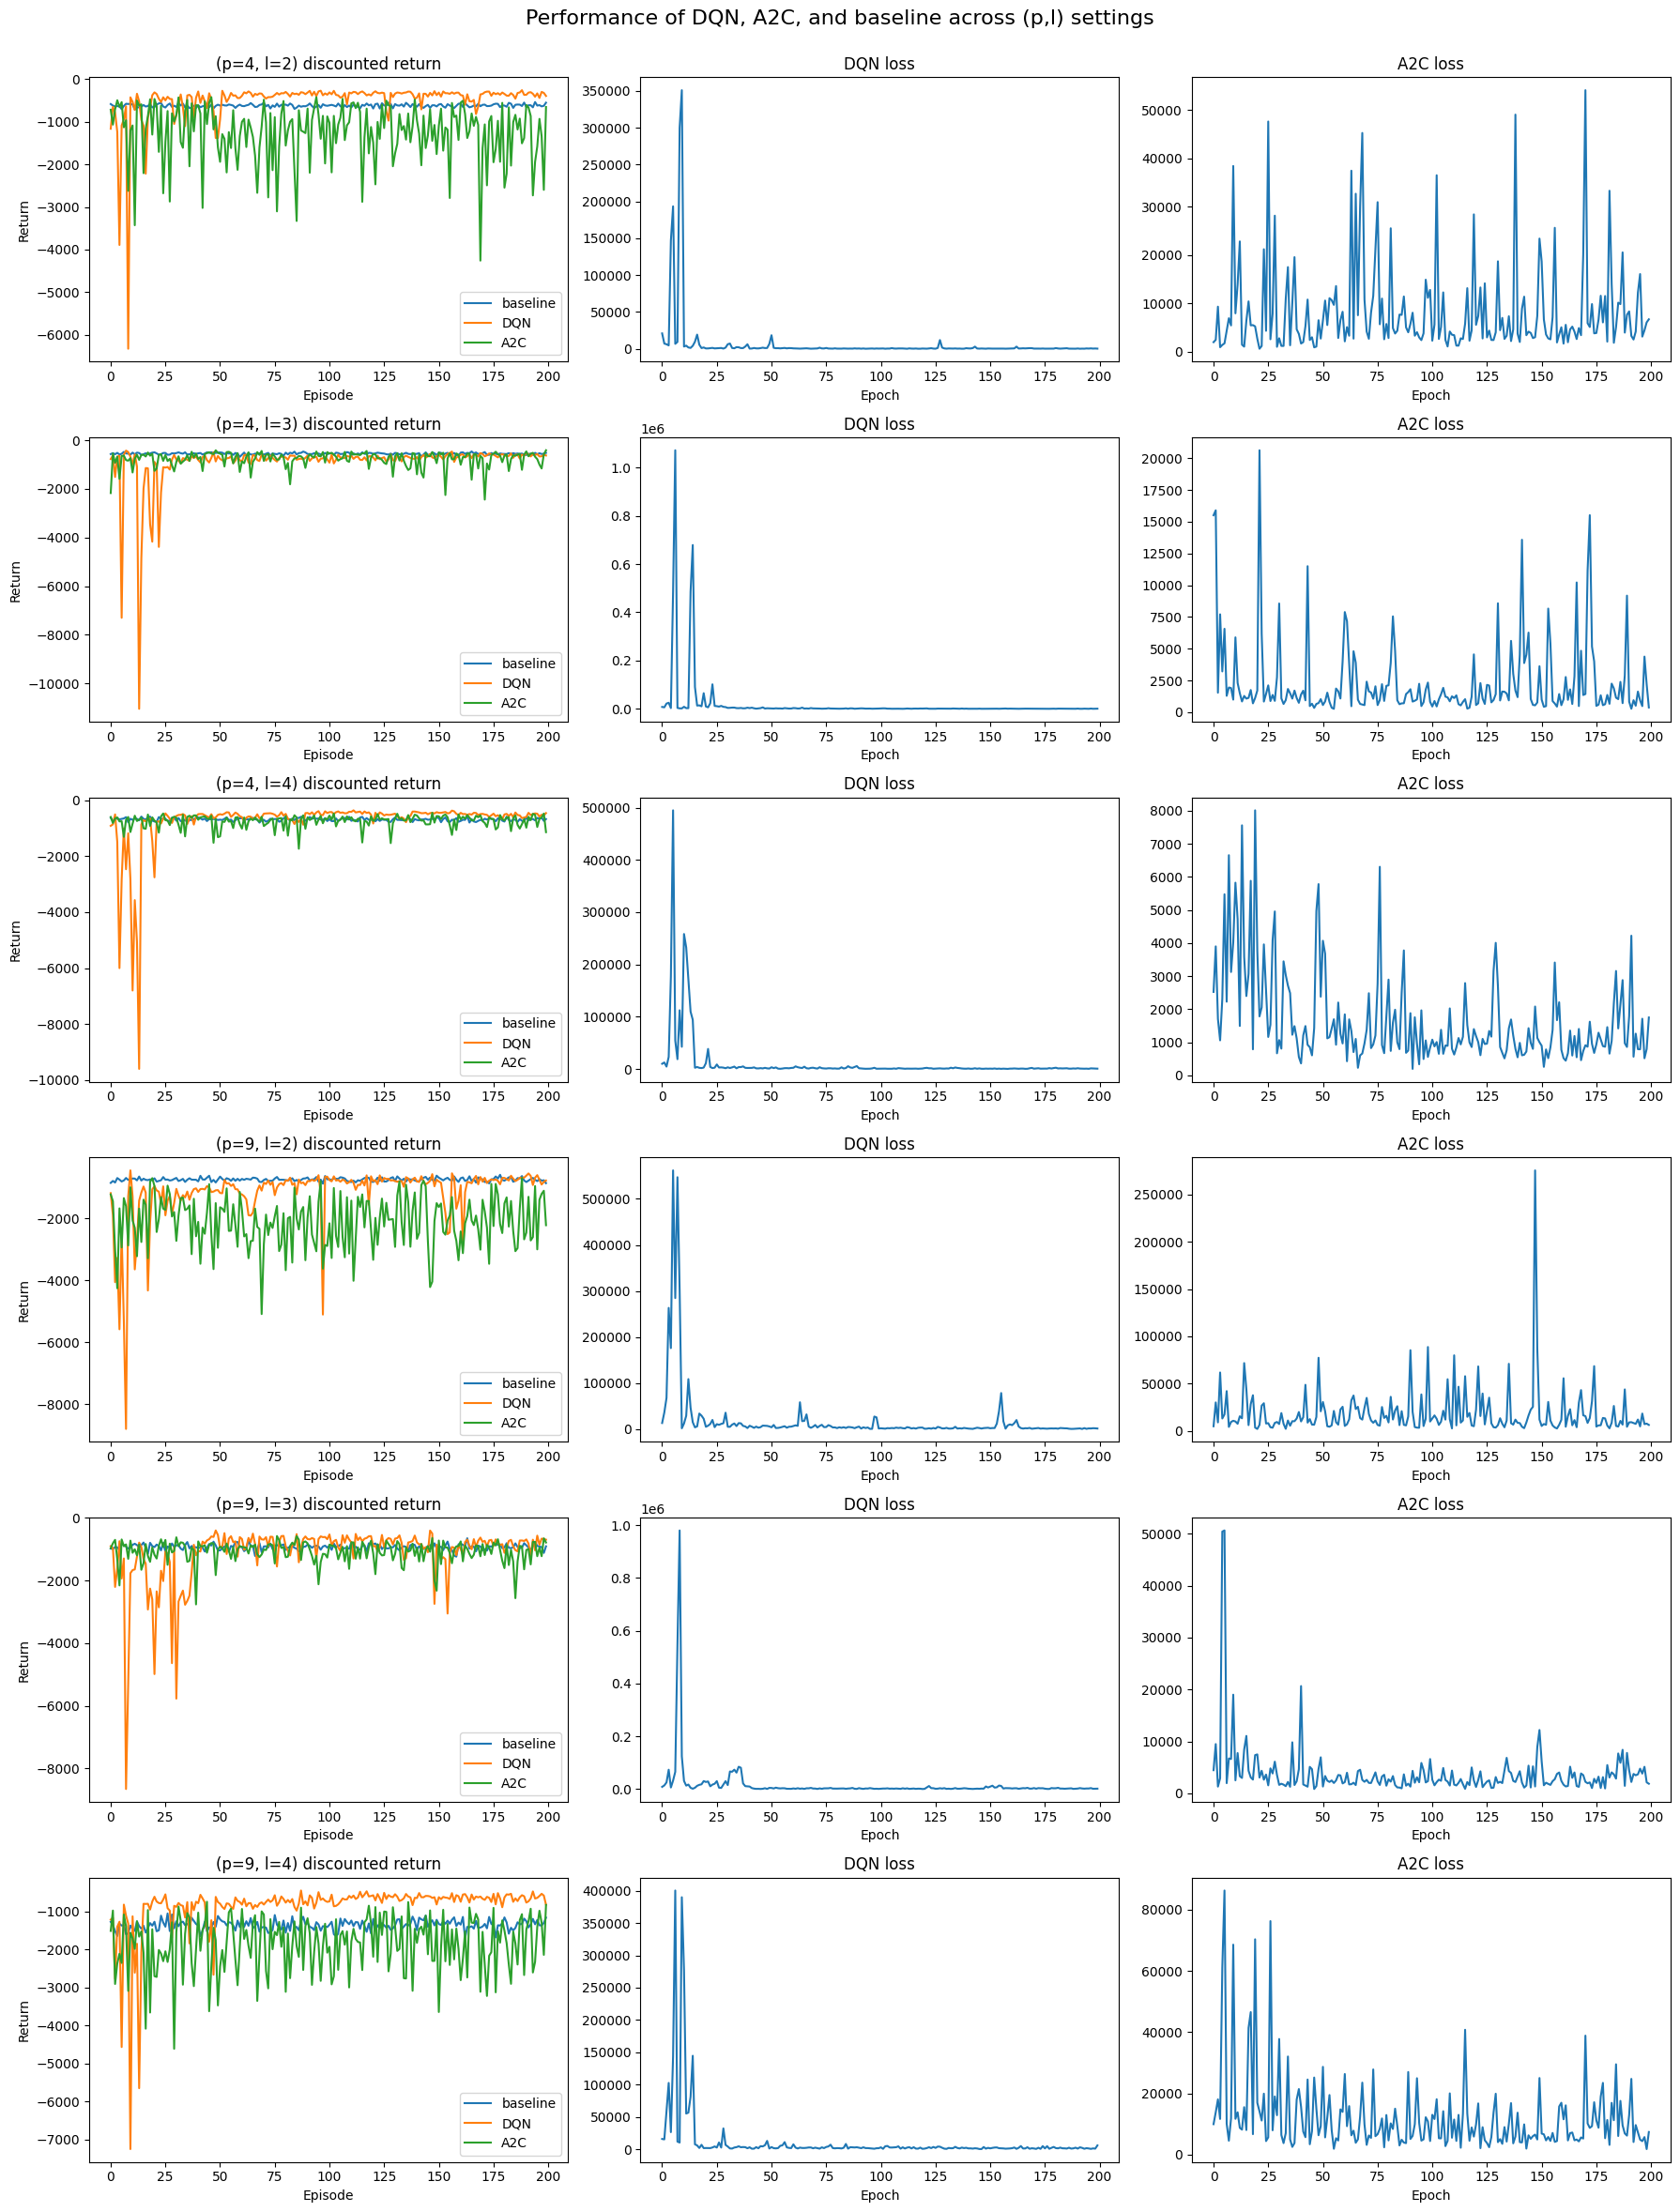

In [ ]:
fig, axes = plt.subplots(len(param_grid), 3, figsize=(18, 4 * len(param_grid)))

for row, (p, l) in enumerate(param_grid):
    v_base, v_dqn, v_ac, l_dqn, l_ac, epoch_l_dqn, epoch_l_ac = results[(p, l)]

    ax_ret = axes[row][0]
    ax_ret.plot(v_base, label='baseline')
    ax_ret.plot(v_dqn , label='DQN')
    ax_ret.plot(v_ac  , label='A2C')
    ax_ret.set_title(f'(p={p}, l={l}) discounted return')
    ax_ret.set_xlabel('Episode')
    ax_ret.set_ylabel('Return')
    ax_ret.legend()

    ax_dqn = axes[row][1]
    ax_dqn.plot(epoch_l_dqn)
    ax_dqn.set_title('DQN loss')
    ax_dqn.set_xlabel('Epoch')

    ax_a2c = axes[row][2]
    ax_a2c.plot(epoch_l_ac)
    ax_a2c.set_title('A2C loss')
    ax_a2c.set_xlabel('Epoch')

fig.suptitle('Performance of DQN, A2C, and baseline across (p,l) settings', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

For simplicity, you can tune your DRL models with network layers no large than $5$ and learning rate between $10^{-5} \sim 10^{-3}$.

# 5.Tuning Hyperparameter for DRL Methods

In [ ]:
hyperparameters = {
    'dqn': {
        'lr': [1e-5, 1e-4, 1e-3]
    },
    'a2c': {
        'lr_a': [1e-5, 1e-4, 1e-3],
        'lr_c': [1e-5, 1e-4, 1e-3]
    },
    'ppo': {
        'lr_a': [5e-5 ,1e-4, 1e-3],
        'lr_c': [5e-5 ,1e-4, 1e-3],
        'lmbda': [0.95]
    },
    'sac': {
        'lr_a': [5e-5 ,1e-4, 1e-3],
        'lr_c': [5e-5 ,1e-4, 1e-3],
        'lr_alpha': [1e-3],
        'target_entropy': [-1],
        'tau': [0.005]
    }
}

In [ ]:
def storeBestModel(p, l, agent, agent_name):
    model_dir = f"/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}"  # Create a directory for each (p, l) combination
    os.makedirs(model_dir, exist_ok=True)
    if 'dqn' in agent_name:
      torch.save({
        'model_state_dict': agent.q.state_dict(),
        }, os.path.join(model_dir, f"{agent_name}_model.pth"))
    else:
       torch.save({
        'actor_state_dict': agent.actor.state_dict(),
        }, os.path.join(model_dir, f"{agent_name}_model.pth"))


In [ ]:
def ModelTune(price, lead, agent_name):
    global env
    env = make_env(price, lead)
    best_reward = float('-inf')
    best_params = None
    best_agent = None

    epochs = 300
    num_steps = 100
    buffer_sample_size = 10
    learn_step = 5
    if agent_name == 'dqn':
        hyperparam = hyperparameters['dqn']
        tgt_update_step = 10
        for lr in tqdm(hyperparam['lr'],desc='lr'):
            agent = DQN_agent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount, lr=lr)
            v, l, epoch_l = train_dqn(env, agent, epochs=epochs, num_steps=num_steps, buffer_sample_size=buffer_sample_size, tgt_update_step=tgt_update_step, learn_step=learn_step)
            if np.mean(v[-100:]) > best_reward:
                best_reward = np.mean(v[-100:])
                best_params = {'lr': lr}
                best_agent = agent
    elif agent_name == 'a2c':
        hyperparam = hyperparameters['a2c']
        for lr_a in tqdm(hyperparam['lr_a'],desc='lr_a'):
            for lr_c in tqdm(hyperparam['lr_c'],desc='lr_c'):
                agent = AC_agent(obs_dim=env.lead+1, act_dim=env.n_action, n_step=env.buffer_size,
                                 gamma=env.discount, lr_a=lr_a, lr_c=lr_c)
                v, l, epoch_l, ent = train_actor_critic(env, agent,
                                      epochs=epochs,
                                      num_steps=num_steps,
                                      buffer_sample_size=buffer_sample_size,
                                      learn_step=learn_step)
                if np.mean(v[-100:]) > best_reward:
                    best_reward = np.mean(v[-100:])
                    best_params = {'lr_a': lr_a, 'lr_c': lr_c}
                    best_agent = agent
    elif agent_name == 'ppo':
        hyperparam = hyperparameters['ppo']
        for lr_a in tqdm(hyperparam['lr_a'],desc='lr_a'):
            for lr_c in tqdm(hyperparam['lr_c'],desc='lr_c'):
                for lmbda in hyperparam['lmbda']:
                    agent = PPOAgent(obs_dim=env.lead+1, act_dim=env.n_action, n_step=env.buffer_size,
                                     gamma=env.discount, lmbda=lmbda, lr_a=lr_a, lr_c=lr_c)
                    v, l, epoch_l, ent = train_actor_critic(env, agent,
                                      epochs=epochs,
                                      num_steps=num_steps,
                                      buffer_sample_size=buffer_sample_size,
                                      learn_step=learn_step)
                    if np.mean(v[-100:]) > best_reward:
                        best_reward = np.mean(v[-100:])
                        best_params = {'lr_a': lr_a, 'lr_c': lr_c, 'lmbda': lmbda}
                        best_agent = agent
    elif agent_name == 'sac':
        hyperparam = hyperparameters['sac']
        for lr_a in tqdm(hyperparam['lr_a'],desc='lr_a'):
            for lr_c in tqdm(hyperparam['lr_c'],desc='lr_c'):
                for lr_alpha in hyperparam['lr_alpha']:
                    for target_entropy in hyperparam['target_entropy']:
                        for tau in hyperparam['tau']:
                            agent = SACAgent(obs_dim=env.lead+1, act_dim=env.n_action,
                                             n_step=env.buffer_size,
                                             gamma=env.discount,
                                             target_entropy=target_entropy,
                                             tau=tau)
                            v, l, epoch_l, ent = train_actor_critic(env, agent,
                                      epochs=epochs,
                                      num_steps=num_steps,
                                      buffer_sample_size=buffer_sample_size,
                                      learn_step=learn_step)
                            if np.mean(v[-100:]) > best_reward:
                                best_reward = np.mean(v[-100:])
                                best_params = {'lr_a': lr_a, 'lr_c': lr_c, 'lr_alpha': lr_alpha, 'target_entropy': target_entropy, 'tau': tau}
                                best_agent = agent

    elif agent_name == 'hudqn':
        hyperparam = hyperparameters['dqn']
        tgt_update_step = 10
        for lr in tqdm(hyperparam['lr'],desc='lr'):
            agent = HuDQN_agent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount, lr=lr)
            v, l, epoch_l = train_dqn(env, agent, epochs=epochs, num_steps=num_steps, buffer_sample_size=buffer_sample_size, tgt_update_step=tgt_update_step, learn_step=learn_step)
            if np.mean(v[-100:]) > best_reward:
                best_reward = np.mean(v[-100:])
                best_params = {'lr': lr}
                best_agent = agent
    elif agent_name == 'hua2c':
        hyperparam = hyperparameters['a2c']
        for lr_a in tqdm(hyperparam['lr_a'],desc='lr_a'):
            for lr_c in tqdm(hyperparam['lr_c'],desc='lr_c'):
                agent = HuAC_agent(obs_dim=env.lead+1, act_dim=env.n_action, n_step=env.buffer_size,
                                 gamma=env.discount, lr_a=lr_a, lr_c=lr_c)
                v, l, epoch_l, ent = train_actor_critic(env, agent,
                                      epochs=epochs,
                                      num_steps=num_steps,
                                      buffer_sample_size=buffer_sample_size,
                                      learn_step=learn_step)
                if np.mean(v[-100:]) > best_reward:
                    best_reward = np.mean(v[-100:])
                    best_params = {'lr_a': lr_a, 'lr_c': lr_c}
                    best_agent = agent
    elif agent_name == 'huppo':
        hyperparam = hyperparameters['ppo']
        for lr_a in tqdm(hyperparam['lr_a'],desc='lr_a'):
            for lr_c in tqdm(hyperparam['lr_c'],desc='lr_c'):
                for lmbda in hyperparam['lmbda']:
                    agent = HuPPOAgent(obs_dim=env.lead+1, act_dim=env.n_action, n_step=env.buffer_size,
                                     gamma=env.discount, lmbda=lmbda, lr_a=lr_a, lr_c=lr_c)
                    v, l, epoch_l, ent = train_actor_critic(env, agent,
                                      epochs=epochs,
                                      num_steps=num_steps,
                                      buffer_sample_size=buffer_sample_size,
                                      learn_step=learn_step)
                    if np.mean(v[-100:]) > best_reward:
                        best_reward = np.mean(v[-100:])
                        best_params = {'lr_a': lr_a, 'lr_c': lr_c, 'lmbda': lmbda}
                        best_agent = agent
    elif agent_name == 'husac':
        hyperparam = hyperparameters['sac']
        for lr_a in tqdm(hyperparam['lr_a'],desc='lr_a'):
            for lr_c in tqdm(hyperparam['lr_c'],desc='lr_c'):
                for lr_alpha in hyperparam['lr_alpha']:
                    for target_entropy in hyperparam['target_entropy']:
                        for tau in hyperparam['tau']:
                            agent = HuSACAgent(obs_dim=env.lead+1, act_dim=env.n_action,
                                             n_step=env.buffer_size,
                                             gamma=env.discount,
                                             target_entropy=target_entropy,
                                             tau=tau)
                            v, l, epoch_l, ent = train_actor_critic(env, agent,
                                      epochs=epochs,
                                      num_steps=num_steps,
                                      buffer_sample_size=buffer_sample_size,
                                      learn_step=learn_step)
                            if np.mean(v[-100:]) > best_reward:
                                best_reward = np.mean(v[-100:])
                                best_params = {'lr_a': lr_a, 'lr_c': lr_c, 'lr_alpha': lr_alpha, 'target_entropy': target_entropy, 'tau': tau}
                                best_agent = agent

    else:
        raise ValueError("Invalid agent name")
    return best_reward, best_params, best_agent

In [ ]:
from tqdm import tqdm
param_grid = [(4, 2),\
        (4, 3),\
        (4, 4),\
        (9, 2),\
        (9, 3),\
        (9, 4)]
agent_list = ['dqn', 'a2c', 'ppo', 'sac']
agent_dict = {}
for (p,l) in tqdm(param_grid,desc='env'):
  for agent_name in tqdm(agent_list,desc=f'agent_{p}_{l}'):
    best_reward, best_params, agent = ModelTune(p, l, agent_name)
    storeBestModel(p, l, agent, agent_name)
    agent_dict[(p,l,agent_name)] = (best_params,agent)
    print(f"Best agent {agent_name} for p={p}, l={l} yielded")
import json
file_path = '/content/drive/MyDrive/Colab Notebooks/models/agent_dict.json'
with open(file_path, 'w') as file:
    json.dump(agent_dict, file)

agent_4_2:   0%|          | 0/4 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:  33%|███▎      | 1/3 [00:21<00:42, 21.11s/it]

lr:  67%|██████▋   | 2/3 [00:41<00:20, 20.85s/it]

lr: 100%|██████████| 3/3 [01:02<00:00, 20.75s/it]

agent_4_2:  25%|██▌       | 1/4 [01:02<03:06, 62.27s/it]

Best agent dqn for p=4, l=2 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:05<02:10, 65.00s/it]


lr_c:  67%|██████▋   | 2/3 [02:10<01:05, 65.13s/it]


lr_c: 100%|██████████| 3/3 [03:15<00:00, 65.12s/it]


lr_a:  33%|███▎      | 1/3 [03:15<06:30, 195.36s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.26s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:03, 63.99s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.23s/it]


lr_a:  67%|██████▋   | 2/3 [06:28<03:13, 193.80s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:03<02:07, 63.99s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.07s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.10s/it]


lr_a: 100%|██████████| 3/3 [09:40<00:00, 193.46s/it]

agent_4_2:  50%|█████     | 2/4 [10:42<12:14, 367.05s/it]

Best agent a2c for p=4, l=2 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-70-48f13f12b065>:36: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))



lr_c:  33%|███▎      | 1/3 [03:48<07:36, 228.08s/it]


lr_c:  67%|██████▋   | 2/3 [07:36<03:48, 228.36s/it]


lr_c: 100%|██████████| 3/3 [11:24<00:00, 228.24s/it]


lr_a:  33%|███▎      | 1/3 [11:24<22:49, 684.73s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:47<07:35, 227.69s/it]


lr_c:  67%|██████▋   | 2/3 [07:34<03:47, 227.37s/it]


lr_c: 100%|██████████| 3/3 [11:24<00:00, 228.02s/it]


lr_a:  67%|██████▋   | 2/3 [22:48<11:24, 684.33s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:48<07:36, 228

Best agent ppo for p=4, l=2 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-71-9db095d5fd81>:57: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(critic_1_q_values, td_target.detach()))
<ipython-input-71-9db095d5fd81>:60: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(critic_2_q_values, td_target.detach()))



lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.38s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.22s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.29s/it]


lr_a:  33%|███▎      | 1/3 [04:42<09:25, 282.87s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08

Best agent sac for p=4, l=2 yielded



agent_4_3:   0%|          | 0/4 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:  33%|███▎      | 1/3 [00:20<00:40, 20.28s/it]

lr:  67%|██████▋   | 2/3 [00:40<00:20, 20.43s/it]

lr: 100%|██████████| 3/3 [01:00<00:00, 20.33s/it]

agent_4_3:  25%|██▌       | 1/4 [01:00<03:02, 61.00s/it]

Best agent dqn for p=4, l=3 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:09, 64.62s/it]


lr_c:  67%|██████▋   | 2/3 [02:09<01:04, 64.53s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.33s/it]


lr_a:  33%|███▎      | 1/3 [03:13<06:26, 193.00s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:09, 64.67s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.35s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.26s/it]


lr_a:  67%|██████▋   | 2/3 [06:25<03:12, 192.87s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.29s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.24s/it]


lr_c: 100%|██████████| 3/3 [03:13<00:00, 64.35s/it]


lr_a: 100%|██████████| 3/3 [09:38<00:00, 192.94s/it]

agent_4_3:  50%|█████     | 2/4 [10:39<12:11, 365.61s/it]

Best agent a2c for p=4, l=3 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:50<07:40, 230.03s/it]


lr_c:  67%|██████▋   | 2/3 [07:39<03:49, 229.82s/it]


lr_c: 100%|██████████| 3/3 [11:28<00:00, 229.60s/it]


lr_a:  33%|███▎      | 1/3 [11:28<22:57, 688.81s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:38, 229.04s/it]


lr_c:  67%|██████▋   | 2/3 [07:37<03:48, 228.76s/it]


lr_c: 100%|██████████| 3/3 [11:28<00:00, 229.43s/it]


lr_a:  67%|██████▋   | 2/3 [22:57<11:28, 688.51s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:39, 229.61s/it]


lr_c:  67%|██████▋   | 2/3 [07:38<03:49, 229.12s/it]


lr_c: 100%|██████████| 3/3 [11:27<00:00, 229.17s/it]


lr_a: 100%|██████████| 3/3 [34:24<00:00, 688.21s/it]

agent_4_3:  75%|███████▌  | 3/4 [45:04<19:01, 1141.43s/it]

Best agent ppo for p=4, l=3 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.29s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.20s/it]


lr_c: 100%|██████████| 3/3 [04:43<00:00, 94.47s/it]


lr_a:  33%|███▎      | 1/3 [04:43<09:26, 283.42s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:33<03:07, 93.95s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.07s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.22s/it]


lr_a:  67%|██████▋   | 2/3 [09:26<04:42, 282.98s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.45s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.47s/it]


lr_c: 100%|██████████| 3/3 [04:43<00:00, 94.42s/it]


lr_a: 100%|██████████| 3/3 [14:09<00:00, 283.12s/it]

env:  33%|███▎      | 2/6 [1:58:19<3:56:41, 3550.35s/it]

Best agent sac for p=4, l=3 yielded



agent_4_4:   0%|          | 0/4 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:  33%|███▎      | 1/3 [00:20<00:41, 20.59s/it]

lr:  67%|██████▋   | 2/3 [00:41<00:20, 20.64s/it]

lr: 100%|██████████| 3/3 [01:01<00:00, 20.55s/it]

agent_4_4:  25%|██▌       | 1/4 [01:01<03:05, 61.67s/it]

Best agent dqn for p=4, l=4 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.43s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.29s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.30s/it]


lr_a:  33%|███▎      | 1/3 [03:12<06:25, 192.92s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.40s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.35s/it]


lr_c: 100%|██████████| 3/3 [03:13<00:00, 64.45s/it]


lr_a:  67%|██████▋   | 2/3 [06:26<03:13, 193.18s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.46s/it]


lr_c:  67%|██████▋   | 2/3 [02:09<01:04, 64.53s/it]


lr_c: 100%|██████████| 3/3 [03:13<00:00, 64.44s/it]


lr_a: 100%|██████████| 3/3 [09:39<00:00, 193.20s/it]

agent_4_4:  50%|█████     | 2/4 [10:41<12:12, 366.34s/it]

Best agent a2c for p=4, l=4 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:38, 229.16s/it]


lr_c:  67%|██████▋   | 2/3 [07:38<03:49, 229.34s/it]


lr_c: 100%|██████████| 3/3 [11:28<00:00, 229.50s/it]


lr_a:  33%|███▎      | 1/3 [11:28<22:57, 688.51s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:39, 229.85s/it]


lr_c:  67%|██████▋   | 2/3 [07:38<03:48, 228.94s/it]


lr_c: 100%|██████████| 3/3 [11:27<00:00, 229.06s/it]


lr_a:  67%|██████▋   | 2/3 [22:55<11:27, 687.73s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:39, 229.67s/it]


lr_c:  67%|██████▋   | 2/3 [07:38<03:48, 228.95s/it]


lr_c: 100%|██████████| 3/3 [11:26<00:00, 228.94s/it]


lr_a: 100%|██████████| 3/3 [34:22<00:00, 687.51s/it]

agent_4_4:  75%|███████▌  | 3/4 [45:03<19:00, 1140.86s/it]

Best agent ppo for p=4, l=4 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:33<03:07, 93.88s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.25s/it]


lr_c: 100%|██████████| 3/3 [04:45<00:00, 95.15s/it]


lr_a:  33%|███▎      | 1/3 [04:45<09:30, 285.46s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.13s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.14s/it]


lr_c: 100%|██████████| 3/3 [04:41<00:00, 93.90s/it]


lr_a:  67%|██████▋   | 2/3 [09:27<04:43, 283.25s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:33<03:07, 93.58s/it]


lr_c:  67%|██████▋   | 2/3 [03:07<01:33, 93.81s/it]


lr_c: 100%|██████████| 3/3 [04:41<00:00, 93.81s/it]


lr_a: 100%|██████████| 3/3 [14:08<00:00, 282.86s/it]

env:  50%|█████     | 3/6 [2:57:31<2:57:33, 3551.30s/it]

Best agent sac for p=4, l=4 yielded



agent_9_2:   0%|          | 0/4 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:  33%|███▎      | 1/3 [00:20<00:40, 20.20s/it]

lr:  67%|██████▋   | 2/3 [00:40<00:20, 20.20s/it]

lr: 100%|██████████| 3/3 [01:00<00:00, 20.27s/it]

agent_9_2:  25%|██▌       | 1/4 [01:00<03:02, 60.81s/it]

Best agent dqn for p=9, l=2 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:03<02:07, 63.75s/it]


lr_c:  67%|██████▋   | 2/3 [02:07<01:03, 63.99s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.11s/it]


lr_a:  33%|███▎      | 1/3 [03:12<06:24, 192.34s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.21s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.04s/it]


lr_c: 100%|██████████| 3/3 [03:11<00:00, 63.98s/it]


lr_a:  67%|██████▋   | 2/3 [06:24<03:12, 192.11s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.27s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.16s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.14s/it]


lr_a: 100%|██████████| 3/3 [09:36<00:00, 192.23s/it]

agent_9_2:  50%|█████     | 2/4 [10:37<12:08, 364.28s/it]

Best agent a2c for p=9, l=2 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:46<07:33, 226.58s/it]


lr_c:  67%|██████▋   | 2/3 [07:36<03:48, 228.35s/it]


lr_c: 100%|██████████| 3/3 [11:24<00:00, 228.14s/it]


lr_a:  33%|███▎      | 1/3 [11:24<22:48, 684.42s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:48<07:37, 228.52s/it]


lr_c:  67%|██████▋   | 2/3 [07:36<03:48, 228.27s/it]


lr_c: 100%|██████████| 3/3 [11:25<00:00, 228.50s/it]


lr_a:  67%|██████▋   | 2/3 [22:49<11:25, 685.07s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:47<07:34, 227.22s/it]


lr_c:  67%|██████▋   | 2/3 [07:34<03:47, 227.45s/it]


lr_c: 100%|██████████| 3/3 [11:22<00:00, 227.56s/it]


lr_a: 100%|██████████| 3/3 [34:12<00:00, 684.20s/it]

agent_9_2:  75%|███████▌  | 3/4 [44:50<18:55, 1135.21s/it]

Best agent ppo for p=9, l=2 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:33<03:07, 93.73s/it]


lr_c:  67%|██████▋   | 2/3 [03:07<01:34, 94.01s/it]


lr_c: 100%|██████████| 3/3 [04:43<00:00, 94.53s/it]


lr_a:  33%|███▎      | 1/3 [04:43<09:27, 283.60s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:09, 94.55s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.33s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.28s/it]


lr_a:  67%|██████▋   | 2/3 [09:26<04:43, 283.16s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.22s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.01s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.16s/it]


lr_a: 100%|██████████| 3/3 [14:08<00:00, 282.98s/it]

env:  67%|██████▋   | 4/6 [3:56:30<1:58:12, 3546.48s/it]

Best agent sac for p=9, l=2 yielded



agent_9_3:   0%|          | 0/4 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:  33%|███▎      | 1/3 [00:20<00:41, 20.51s/it]

lr:  67%|██████▋   | 2/3 [00:41<00:20, 20.51s/it]

lr: 100%|██████████| 3/3 [01:01<00:00, 20.46s/it]

agent_9_3:  25%|██▌       | 1/4 [01:01<03:04, 61.38s/it]

Best agent dqn for p=9, l=3 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.07s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.22s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.03s/it]


lr_a:  33%|███▎      | 1/3 [03:12<06:24, 192.09s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:03<02:07, 63.99s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.15s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.24s/it]


lr_a:  67%|██████▋   | 2/3 [06:24<03:12, 192.47s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.28s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.12s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.06s/it]


lr_a: 100%|██████████| 3/3 [09:37<00:00, 192.33s/it]

agent_9_3:  50%|█████     | 2/4 [10:38<12:09, 364.70s/it]

Best agent a2c for p=9, l=3 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:39, 229.92s/it]


lr_c:  67%|██████▋   | 2/3 [07:39<03:49, 229.63s/it]


lr_c: 100%|██████████| 3/3 [11:29<00:00, 229.93s/it]


lr_a:  33%|███▎      | 1/3 [11:29<22:59, 689.80s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:38, 229.40s/it]


lr_c:  67%|██████▋   | 2/3 [07:39<03:49, 229.68s/it]


lr_c: 100%|██████████| 3/3 [11:28<00:00, 229.65s/it]


lr_a:  67%|██████▋   | 2/3 [22:58<11:29, 689.31s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:48<07:37, 228.55s/it]


lr_c:  67%|██████▋   | 2/3 [07:37<03:48, 228.57s/it]


lr_c: 100%|██████████| 3/3 [11:26<00:00, 228.82s/it]


lr_a: 100%|██████████| 3/3 [34:25<00:00, 688.41s/it]

agent_9_3:  75%|███████▌  | 3/4 [45:03<19:01, 1141.21s/it]

Best agent ppo for p=9, l=3 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.35s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.21s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.29s/it]


lr_a:  33%|███▎      | 1/3 [04:42<09:25, 282.87s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.49s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.38s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.25s/it]


lr_a:  67%|██████▋   | 2/3 [09:25<04:42, 282.81s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.46s/it]


lr_c:  67%|██████▋   | 2/3 [03:09<01:34, 94.56s/it]


lr_c: 100%|██████████| 3/3 [04:43<00:00, 94.61s/it]


lr_a: 100%|██████████| 3/3 [14:09<00:00, 283.16s/it]

env:  83%|████████▎ | 5/6 [4:55:43<59:08, 3548.89s/it]  

Best agent sac for p=9, l=3 yielded



agent_9_4:   0%|          | 0/4 [00:00<?, ?it/s]

lr:   0%|          | 0/3 [00:00<?, ?it/s]

lr:  33%|███▎      | 1/3 [00:20<00:40, 20.46s/it]

lr:  67%|██████▋   | 2/3 [00:41<00:20, 20.56s/it]

lr: 100%|██████████| 3/3 [01:01<00:00, 20.43s/it]

agent_9_4:  25%|██▌       | 1/4 [01:01<03:03, 61.30s/it]

Best agent dqn for p=9, l=4 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:03<02:07, 63.94s/it]


lr_c:  67%|██████▋   | 2/3 [02:07<01:03, 63.93s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.02s/it]


lr_a:  33%|███▎      | 1/3 [03:12<06:24, 192.05s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:04<02:08, 64.07s/it]


lr_c:  67%|██████▋   | 2/3 [02:08<01:04, 64.10s/it]


lr_c: 100%|██████████| 3/3 [03:12<00:00, 64.17s/it]


lr_a:  67%|██████▋   | 2/3 [06:24<03:12, 192.33s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:03<02:07, 63.72s/it]


lr_c:  67%|██████▋   | 2/3 [02:07<01:03, 63.79s/it]


lr_c: 100%|██████████| 3/3 [03:11<00:00, 63.86s/it]


lr_a: 100%|██████████| 3/3 [09:36<00:00, 192.05s/it]

agent_9_4:  50%|█████     | 2/4 [10:37<12:08, 364.16s/it]

Best agent a2c for p=9, l=4 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:39, 229.60s/it]


lr_c:  67%|██████▋   | 2/3 [07:39<03:49, 229.92s/it]


lr_c: 100%|██████████| 3/3 [11:28<00:00, 229.53s/it]


lr_a:  33%|███▎      | 1/3 [11:28<22:57, 688.58s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:39, 229.50s/it]


lr_c:  67%|██████▋   | 2/3 [07:39<03:50, 230.05s/it]


lr_c: 100%|██████████| 3/3 [11:28<00:00, 229.66s/it]


lr_a:  67%|██████▋   | 2/3 [22:57<11:28, 688.81s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [03:49<07:38, 229.36s/it]


lr_c:  67%|██████▋   | 2/3 [07:38<03:49, 229.06s/it]


lr_c: 100%|██████████| 3/3 [11:26<00:00, 228.97s/it]


lr_a: 100%|██████████| 3/3 [34:24<00:00, 688.16s/it]

agent_9_4:  75%|███████▌  | 3/4 [45:01<19:00, 1140.56s/it]

Best agent ppo for p=9, l=4 yielded




lr_a:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:09, 94.54s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.35s/it]


lr_c: 100%|██████████| 3/3 [04:43<00:00, 94.43s/it]


lr_a:  33%|███▎      | 1/3 [04:43<09:26, 283.30s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:08, 94.14s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.17s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.19s/it]


lr_a:  67%|██████▋   | 2/3 [09:25<04:42, 282.87s/it]


lr_c:   0%|          | 0/3 [00:00<?, ?it/s]


lr_c:  33%|███▎      | 1/3 [01:34<03:09, 94.66s/it]


lr_c:  67%|██████▋   | 2/3 [03:08<01:34, 94.35s/it]


lr_c: 100%|██████████| 3/3 [04:42<00:00, 94.30s/it]


lr_a: 100%|██████████| 3/3 [14:08<00:00, 282.93s/it]

env: 100%|██████████| 6/6 [5:54:54<00:00, 3549.10s/it]

Best agent sac for p=9, l=4 yielded


# 6.Heuristic Algorithms
Here we provide some heuristic algorithms for you to compare with the DRL algorithms:


*   Base stock policy: If we set the base-stock level to be $S$, then the order at time $t$ is: $q_t = \max(0,  S - I_{t-1} - \sum\limits_{i=1}^{L-1} q_{t-L+i})$
*   Capped base stock policy: If we set the base-stock level to be $S$ and the maximum order capacity to be $r$, then the order at time $t$ is: $q_t = \min(r, \max(0,  S - I_{t-1} - \sum\limits_{i=1}^L q_{t-L+i}))$
*   Constant order policy: $q_t = r$.
*   Myopic-1 policy: Choose the smallest $z$ such that the onhand inventory after fulfilling demands $I_{t+L}$ satisfies: $\mathrm{P}(I_{t+L} < 0\vert q_0, \dots, q_{t-1}, q_t = z) = \frac{c+h}{p+h}$. $I_{t+L}$ is a function of $I_{t-1}, d_t, \dots, d_{t+L}, q_t$.

In [ ]:
import itertools
def Basestock(obs, **kwargs):
  ### BEGIN HERE
  I = obs[0]
  pipeline = sum(obs[1:])
  S = kwargs.get('S', 0)
  action = max(0, S - (I + pipeline))
  ### END HERE
  return action

def Cappedbasestock(obs,**kwargs):
  ### BEGIN HERE
  I = obs[0]
  pipeline = sum(obs[1:])
  S = kwargs.get('S', 0)
  q_max = kwargs.get('q_max', None)
  action = max(0, S - (I + pipeline))
  if q_max is not None:
      action= min(action, q_max)
  ### END HERE
  return action

def Constantorder(obs,**kwargs):
  ### BEGIN HERE
  r = kwargs.get('r', 0)
  action = max(0, r)
  ### END HERE
  return action

def Myopic1(obs,**kwargs):
  ### BEGIN HERE
  I = obs[0]
  pipeline = sum(obs[1:])
  lam = kwargs.get('lambda', 5.0)
  l = kwargs.get('l', 2)
  q_max = kwargs.get('q_max', None)
  p = kwargs.get('p', 4)
  h = kwargs.get('h', 1)

  lam_L = lam * l # parameter of the sum of poisson distributions
  alpha = h / (p + h) # ordering cost c=0
  k = 0 ; cdf = 0.0
  from math import exp, factorial
  while True:
      pmf  = exp(-lam_L) * lam_L**k / factorial(k)
      cdf += pmf
      if 1 - cdf <= alpha: # P(I_t<0) = P(I_{t-1}+pipeline+z-D_L<0) = P(D_L>I_{t-1}+pipeline+z) = 1-P(D_L<=I_{t-1}+pipeline+z)
          break
      k += 1

  action = max(0, k - (I + pipeline))
  if q_max is not None:
      action = min(action, q_max)
  ### END HERE
  return action

Run the heuristic algorithms and find the optimal policy for each policy class(e.g. for base stock you need to search for the optimal base-stock level).

In [ ]:
### BEGIN HERE
def evaluate_policy(env, func, sim_steps=10000, n_repl=5, **kwargs):
    obs  = env.reset()
    ret, discount = 0.0, 1.0
    for _ in range(sim_steps):
        a = func(obs, **kwargs)
        obs, r = env.env_step(a)
        ret += discount * r
        discount *= env.discount
    return ret
### END HERE

In [ ]:
def grid_search_basestock(p=4, l=2, S_grid=range(5, 41, 2)):
    env = make_env(p, l)
    best_S, best_ret = None, -np.inf
    for S in S_grid:
        ret = evaluate_policy(env, Basestock, sim_steps=20_000, S=S)
        if ret > best_ret:
            best_S, best_ret = S, ret
    return best_S, best_ret


def grid_search_capped(p=4, l=2,\
            S_grid=range(5, 41, 5),\
            q_grid=(5, 10, 15, 20)):
    env = make_env(p, l)
    best_pair, best_ret = None, -np.inf
    for S, q in itertools.product(S_grid, q_grid):
        ret = evaluate_policy(env, Cappedbasestock,
                              sim_steps=20_000,
                              S=S, q_max=q)
        if ret > best_ret:
            best_pair, best_ret = (S, q), ret
    return best_pair, best_ret


def grid_search_constant(p=4, l=2, r_grid=range(2, 21, 2)):
    env = make_env(p, l)
    best_r, best_ret = None, -np.inf
    for r in r_grid:
        ret = evaluate_policy(env, Constantorder,
                    sim_steps=20_000,
                    r=r)
        if ret > best_ret:
            best_r, best_ret = r, ret
    return best_r, best_ret


def eval_myopic(p=4, l=2):
    env = make_env(p, l)
    ret = evaluate_policy(env,\
        Myopic1,sim_steps=20_000,\
        p=p, h=1, lamda=5.0, l=l)
    return ret



In [ ]:
param_grid = [(4, 2), (4, 3), (4, 4),\
              (9, 2), (9, 3), (9, 4)]

results = {}

for (p, l) in param_grid:
    print(f" \033[1mHeuristic search for p={p}, l={l}\033[0m")

    best_S, val_bs = grid_search_basestock(p, l)
    print(f" Basestock: best S={best_S:2d}, value={val_bs:.1f}")

    (best_Sc, best_q), val_cap = grid_search_capped(p, l)
    print(f" Cappedbasestock: best S={best_S:2d}, q_max={best_q:2d}, value={val_cap:.1f}")

    best_r,   val_con = grid_search_constant(p, l)
    print(f" Constantorder: best r={best_r:2d}, value={val_con:.1f}")

    val_myo = eval_myopic(p, l)
    print(f" Myopic1: value={val_myo:.1f}")

    results[(p, l)] = dict(
        Basestock = dict(S=best_S,   value=val_bs),
        Cappedbasestock = dict(S=best_Sc, q_max=best_q, value=val_cap),
        Constantorder = dict(r=best_r,  value=val_con),
        Myopic1 = dict(value=val_myo)
    )

 Heuristic search for p=4, l=2
 Basestock: best S=15, value=-475.9
 Cappedbasestock: best S=15, q_max=20, value=-444.4
 Constantorder: best r= 4, value=-480.7
 Myopic1: value=-480.9
 Heuristic search for p=4, l=3
 Basestock: best S=19, value=-519.7
 Cappedbasestock: best S=19, q_max= 5, value=-523.6
 Constantorder: best r= 4, value=-548.3
 Myopic1: value=-554.1
 Heuristic search for p=4, l=4
 Basestock: best S=25, value=-538.0
 Cappedbasestock: best S=25, q_max= 5, value=-526.2
 Constantorder: best r= 4, value=-535.1
 Myopic1: value=-630.5
 Heuristic search for p=9, l=2
 Basestock: best S=19, value=-639.4
 Cappedbasestock: best S=19, q_max= 5, value=-663.0
 Constantorder: best r= 4, value=-1086.3
 Myopic1: value=-964.8
 Heuristic search for p=9, l=3
 Basestock: best S=25, value=-798.0
 Cappedbasestock: best S=25, q_max=10, value=-750.1
 Constantorder: best r= 4, value=-1188.6
 Myopic1: value=-941.1
 Heuristic search for p=9, l=4
 Basestock: best S=31, value=-867.9
 Cappedbasestock: bes

In [ ]:
# GridSearch Results
hu_dict = { # CappedBasedStock
    (4, 2): (15,5),
    (4, 3): (21,10),
    (4, 4): (21,5),
    (9, 2): (19,5),
    (9, 3): (23,5),
    (9, 4): (29,10)
}

Run your DRL and heuristic algorithms, compare their performance. For your reference, I provide the average performance for the four heuristic algorithms(the performance is calculated using the following equation), but you still need to write your own codes and derive the performance:
\begin{equation*}
avg = (1-\gamma)* \sum\limits_{t=0}^{T = 1000} \gamma^t \mathrm{E}^{\pi^{\ast}}[c(S_t,a_t)]
\end{equation*}
where ${\pi^{\ast}}$ is the optimal policy in policy class base-stock, capped base stock, constant order and myopic-1 policy class, starting from state with no stocks. \\
Base stock policy: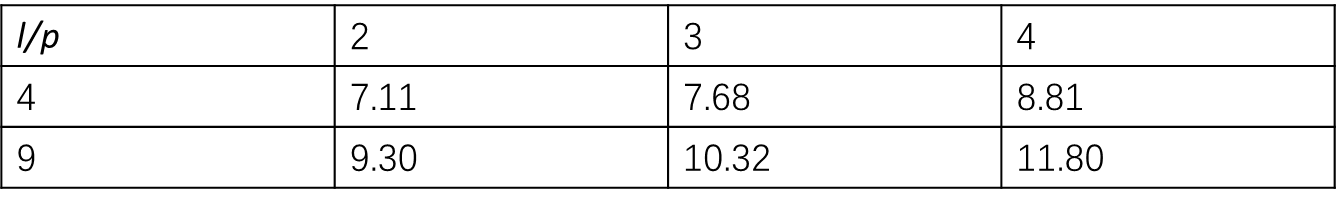
Capped Base Stock Policy: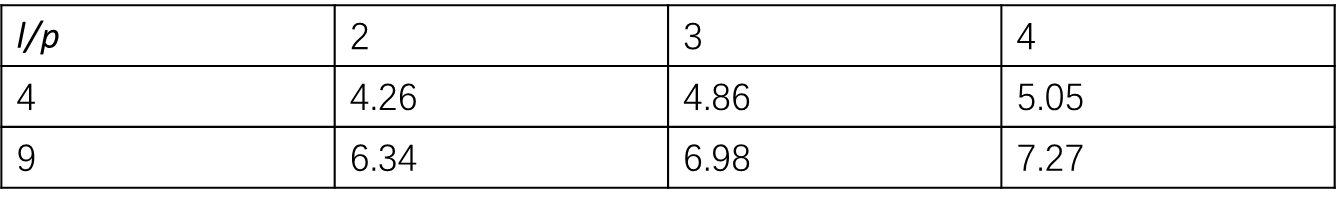
Constant Order: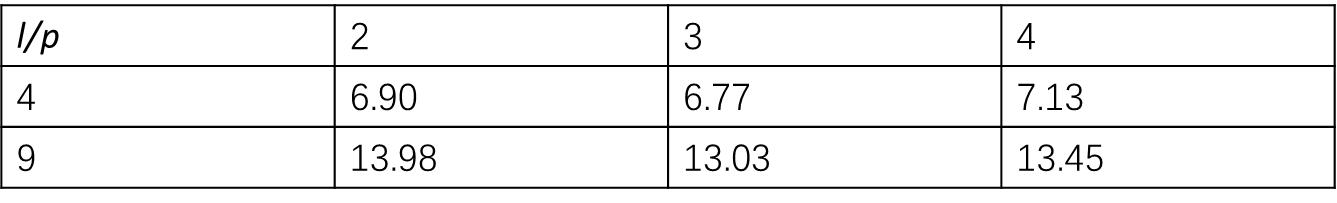
Myopic-1 Policy: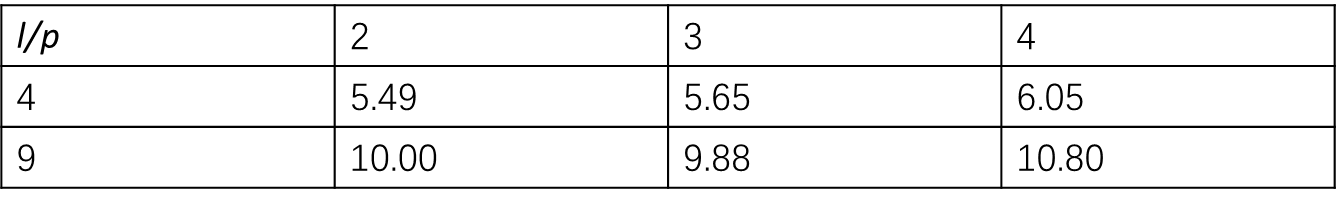


In [ ]:
### BEGIN HERE
def eval_avg(env, policy, T=1000, n_roll=20, **kwargs):
    act_func = lambda x: policy.act(x) if hasattr(policy,'act') else policy(x,**kwargs)
    gamma  = env.discount
    values = []
    for _ in range(n_roll):
        obs   = env.reset()
        disc  = 1.0
        cost  = 0.0
        for _ in range(T):
            a = act_func(obs)
            obs, r = env.env_step(a) # reward = -cost
            cost -= disc * r
            disc *= gamma
        values.append((1-gamma)*cost)
    return np.mean(values)
### END HERE


In [ ]:
from pandas import DataFrame
row_bs = []
row_cbs = []
row_cst = []
row_myo = []
for env, policies_results in results.items():
  for policy_name, opt_params in policies_results.items():
    p,l = env[0], env[1]
    row = None
    if policy_name == 'Basestock':
        policy_func = Basestock
        row = row_bs
    elif policy_name == 'Cappedbasestock':
        policy_func = Cappedbasestock
        row = row_cbs
    elif policy_name == 'Constantorder':
        policy_func = Constantorder
        row = row_cst
    elif policy_name == 'Myopic1':
        policy_func = Myopic1
        row = row_myo
    else:
        raise ValueError(f"Unknown policy name: {policy_name}")

    val = eval_avg(make_env(p,l), policy_func, **opt_params)
    row.append([p,l,round(val,2)])
bs_df = DataFrame(row_bs ,columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
cbs_df = DataFrame(row_cbs, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
cst_df = DataFrame(row_cst, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
myo_df = DataFrame(row_myo, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')

In [ ]:
display(bs_df.style.set_caption('Basestock'))
display(cbs_df.style.set_caption('Cappedbasestock'))
display(cst_df.style.set_caption('Constantorder'))
display(myo_df.style.set_caption('Myopic1'))

l,2,3,4
p,,,
4,5.090000,5.770000,6.580000
9,7.300000,8.370000,9.010000


l,2,3,4
p,,,
4,4.830000,5.660000,6.570000
9,7.380000,8.030000,9.110000


l,2,3,4
p,,,
4,5.490000,5.760000,5.800000
9,10.870000,11.100000,11.350000


l,2,3,4
p,,,
4,5.860000,8.430000,10.740000
9,11.610000,18.570000,23.570000


## Compared to DRL methods
Assume the DRL agents trained are used.

In [ ]:
dqn_row = []
a2c_row = []
ppo_row = []
sac_row = []
for (p, l) in param_grid:
  env = make_env(p,l)
  dqn_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/dqn_model.pth')
  dqn_policy = DQN_agent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  dqn_policy.q.load_state_dict(dqn_dict['model_state_dict'])
  dqn_eval = eval_avg(env,dqn_policy)

  a2c_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/a2c_model.pth')
  a2c_policy = AC_agent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  a2c_policy.actor.load_state_dict(a2c_dict['actor_state_dict'])
  a2c_eval = eval_avg(env,a2c_policy)

  ppo_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/ppo_model.pth')
  ppo_policy = PPOAgent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  ppo_policy.actor.load_state_dict(ppo_dict['actor_state_dict'])
  ppo_eval = eval_avg(env,ppo_policy)

  sac_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/sac_model.pth')
  sac_policy = SACAgent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  sac_policy.actor.load_state_dict(sac_dict['actor_state_dict'])
  sac_eval = eval_avg(env,sac_policy)

  dqn_row.append([p,l,round(dqn_eval,2)])
  a2c_row.append([p,l,round(a2c_eval,2)])
  ppo_row.append([p,l,round(ppo_eval,2)])
  sac_row.append([p,l,round(sac_eval,2)])
dqn_df = DataFrame(dqn_row ,columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
a2c_df = DataFrame(a2c_row, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
ppo_df = DataFrame(ppo_row, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
sac_df = DataFrame(sac_row, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')

In [ ]:
display(dqn_df.style.set_caption('DQN'))
display(a2c_df.style.set_caption('A2C'))
display(ppo_df.style.set_caption('PPO'))
display(sac_df.style.set_caption('SAC'))

l,2,3,4
p,,,
4,7.160000,6.620000,5.810000
9,9.090000,13.850000,17.240000


l,2,3,4
p,,,
4,6.860000,5.880000,6.060000
9,9.420000,9.510000,15.910000


l,2,3,4
p,,,
4,11.770000,12.180000,13.570000
9,17.550000,17.110000,16.880000


l,2,3,4
p,,,
4,28.500000,25.890000,28.770000
9,27.840000,26.210000,39.500000


**Additional**: Can you improve your DRL algorithms(to make it converge faster or perform better) based on the provided heuristic algorithms? You may refer to https://proceedings.neurips.cc/paper_files/paper/2021/file/70d31b87bd021441e5e6bf23eb84a306-Paper.pdf and codes are available on https://github.com/microsoft/HuRL.

# 7.HuRL Agents

In [ ]:
def cal_hurl_target(hu_func,value_net,buf,lmbda,gamma,n_step,q_flag=False):
    next_state_n = buf[-1][-1]
    nextstates = torch.tensor(np.array([traj[-1] for traj in buf]),dtype=torch.float,device=device)
    h_next = hu_func(nextstates)
    rewards = torch.tensor(np.array([traj[2] for traj in buf]),dtype=torch.float,device=device)
    reshaped_rewards = rewards + (1 - lmbda.item()) * gamma * h_next


    # Calculate n-step return with modified discount
    modified_gamma = lmbda * gamma
    cum_r = sum((modified_gamma ** t) * r for t, r in enumerate(reshaped_rewards))
    cum_r = torch.tensor(cum_r,dtype=torch.float32,device=device)

    with torch.no_grad():
      if q_flag:
        v_next = value_net(torch.tensor(next_state_n, dtype=torch.float32, device=device)).max().item()
      else:
        v_next = value_net(torch.tensor(next_state_n, dtype=torch.float32, device=device))
    hu_next = torch.tensor(hu_func(torch.tensor([next_state_n])),dtype=torch.float32,device=device)[0]
    target = cum_r + (modified_gamma ** n_step) * v_next + \
            (gamma ** n_step - modified_gamma ** n_step) * hu_next
    return torch.tensor(target,dtype=torch.float32,device=device)


def heuristic(obs_batch):
    global S, q_max
    I = obs_batch[:, 0]
    pipeline = obs_batch[:, 1:].sum(dim=1)

    mean_demand = torch.tensor(5.0, dtype=torch.float32, device=obs_batch.device)
    zero = torch.tensor(0.0, dtype=torch.float32, device=obs_batch.device)

    next_state_0 = torch.clamp(I + obs_batch[:, 1] - mean_demand, min=0, max=q_max)
    action = S - (I + pipeline)
    action = torch.clamp(action, min=0, max=q_max)

    global env
    cost = next_state_0 + env.p * torch.max(zero, mean_demand - I - obs_batch[:, 1])
    rewards = -cost
    return rewards


class HuAC_agent:
    def __init__(self, obs_dim, act_dim, n_step, gamma, lr_a=1e-3, lr_c=1e-3, lmbda=0, lmbda_schedule_steps=1000):
        self.n, self.g = n_step, gamma
        self.actor = Policy(obs_dim, act_dim).to(device)
        self.critic = Value(obs_dim).to(device)
        self.opt_a = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.opt_c = optim.Adam(self.critic.parameters(), lr=lr_c)
        self.lmbda_init = torch.tensor(lmbda,dtype=torch.float32,device=device)
        self.current_lmbda = self.lmbda_init
        self.lmbda_schedule_steps = lmbda_schedule_steps
        self.step_count = 0

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float, device=device).unsqueeze(0)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def _update_lambda(self):
        scale = torch.tensor(5.0,dtype=torch.float32,device=device)
        self.current_lmbda = self.lmbda_init + (1 - self.lmbda_init) * (1 - torch.exp(-scale * self.step_count/self.lmbda_schedule_steps))
        self.step_count += 1

    def update(self, buf):
        self._update_lambda()
        curr_state = buf[0][0]
        next_state_n = buf[-1][-1]
        target = cal_hurl_target(heuristic,self.critic,buf,self.current_lmbda,self.g,self.n)
        v_curr = self.critic(torch.tensor(curr_state,dtype=torch.float32,device=device))
        TD_error = target - v_curr
        critic_loss = TD_error.pow(2)/2

        states = torch.tensor(np.array([traj[0] for traj in buf]),dtype=torch.float).to(device)
        actions = torch.tensor(np.array([traj[1] for traj in buf])).to(device).unsqueeze(1)
        log_probs = torch.log(self.actor(states).gather(1, actions)+1e-8)
        actor_loss = torch.mean(-log_probs * TD_error.detach())

        self.opt_a.zero_grad()
        self.opt_c.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        self.opt_a.step()
        self.opt_c.step()
        return actor_loss.item() + critic_loss.item()

class HuDQN_agent(object):
  "Agent for the Deep Q Learning"
  "Your code should include the training process(update parameters) and action selection"
  def __init__(self, obs_dim, act_dim, n_step, gamma, lr=1e-3, lmbda=0, lmbda_schedule_steps=1000):
        self.n, self.g = n_step, gamma
        self.q = QNetwork(obs_dim, act_dim).to(device)
        self.q_tgt = copy.deepcopy(self.q).eval()
        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.act_dim = act_dim
        self.eps, self.eps_end, self.eps_dec = 1.0, 0.05, 500
        self.lmbda_init = torch.tensor(lmbda,dtype=torch.float32,device=device)
        self.current_lmbda = self.lmbda_init
        self.lmbda_schedule_steps = lmbda_schedule_steps
        self.step_count = 0

  def act(self, obs):
        if random.random() < self._epsilon():
            return random.randrange(self.act_dim)
        with torch.no_grad():
            q = self.q(torch.tensor(obs,dtype=torch.float32,device=device))
        return int(q.argmax().item())

  def _update_lambda(self):
        scale = torch.tensor(5.0,dtype=torch.float32,device=device)
        self.current_lmbda = self.lmbda_init + (1 - self.lmbda_init) * (1 - torch.exp(-scale * self.step_count/self.lmbda_schedule_steps))
        self.step_count += 1

  def _epsilon(self):
        self.eps = max(self.eps_end, self.eps - (1 - self.eps_end) / self.eps_dec)
        return self.eps

  def learn(self, buf):
        self._update_lambda()
        curr_state = buf[0][0]
        curr_action = buf[0][1]
        q_curr = self.q(torch.tensor(curr_state,dtype=torch.float32).to(device))[curr_action]
        target = cal_hurl_target(heuristic,self.q_tgt,buf,self.current_lmbda,self.g,self.n,q_flag=True)
        TD_error = target - q_curr
        loss = TD_error.pow(2)/2
        self.opt.zero_grad(); loss.backward(); self.opt.step()
        return loss.item()

  def update_tgt(self):
        self.q_tgt.load_state_dict(self.q.state_dict())

class HuPPOAgent:
    def __init__(self, obs_dim, act_dim, n_step, gamma, lmbda=0.95, lr_a=3e-4, lr_c=3e-3, hu_lmbda=0, lmbda_schedule_steps=1000):
        self.n, self.g, self.l = n_step, gamma, lmbda
        self.actor = Policy(obs_dim, act_dim).to(device)
        self.critic = Value(obs_dim).to(device)
        self.opt_a = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.opt_c = optim.Adam(self.critic.parameters(), lr=lr_c)
        self.lr_sch_a = optim.lr_scheduler.StepLR(self.opt_a, step_size=500, gamma=0.1)
        self.lr_sch_c = optim.lr_scheduler.StepLR(self.opt_c, step_size=500, gamma=0.1)
        self.K_epochs = 10
        self.eps_clip = 0.2
        self.hu_lmbda_init = torch.tensor(hu_lmbda,dtype=torch.float32,device=device)
        self.hu_lmbda = self.hu_lmbda_init
        self.lmbda_schedule_steps = lmbda_schedule_steps
        self.step_count = 0



    def act(self, obs):
          logits = self.actor(torch.tensor(obs, dtype=torch.float, device=device))
          dist = torch.distributions.Categorical(logits=logits)
          return int(dist.sample().item())

    def _update_lambda(self):
        scale = torch.tensor(5.0,dtype=torch.float32,device=device)
        self.hu_lmbda = self.hu_lmbda_init + (1 - self.hu_lmbda_init) * (1 - torch.exp(-scale * self.step_count/self.lmbda_schedule_steps))
        self.step_count += 1

    def update(self, buf):
        self._update_lambda()
        states = torch.tensor([traj[0] for traj in buf],dtype=torch.float32).to(device)
        actions = torch.tensor([traj[1] for traj in buf]).to(device).unsqueeze(1)
        rewards = torch.tensor([traj[2] for traj in buf],dtype=torch.float32).to(device)
        nextstates = torch.tensor([traj[-1] for traj in buf],dtype=torch.float32).to(device)
        hu_nexts = heuristic(nextstates)
        new_rewards = rewards + (1 - self.hu_lmbda) * self.g * hu_nexts
        new_gamma = self.hu_lmbda * self.g
        td_target = new_rewards + new_gamma * self.critic(nextstates)
        td_delta = td_target - self.critic(states)
        advantage = self.compute_advantage(td_delta.cpu()).to(device)
        old_log_probs = torch.log(self.actor(states).gather(1,actions)+1e-8).detach()

        for _ in range(self.K_epochs):
            log_probs = torch.log(self.actor(states).gather(1, actions)+1e-8)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip,1 + self.eps_clip) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.opt_a.zero_grad()
            self.opt_c.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.opt_a.step(); self.lr_sch_a.step()
            self.opt_c.step(); self.lr_sch_c.step()
        return (actor_loss + critic_loss).item()


    def compute_advantage(self, td_delta):
        td_delta = td_delta.detach().numpy()
        advantage_list = []
        advantage = 0.0
        for delta in td_delta[::-1]:
            advantage = self.g * self.l * advantage + delta
            advantage_list.append(advantage)
        advantage_list.reverse()
        return torch.tensor(advantage_list, dtype=torch.float)

class HuSACAgent:
    def __init__(self, obs_dim, act_dim, n_step, gamma, target_entropy=-1, tau=0.005, lr_a=3e-4, lr_c=3e-3, lr_alpha=1e-2, lmbda=0, lmbda_schedule_steps=1000):
        self.n, self.g = n_step, gamma
        self.target_entropy = target_entropy
        self.tau = tau
        self.actor = Policy(obs_dim, act_dim).to(device)
        self.critic1 = QNetwork(obs_dim, act_dim).to(device)
        self.critic2 = QNetwork(obs_dim, act_dim).to(device)
        self.critic1_tgt = copy.deepcopy(self.critic1).eval()
        self.critic2_tgt = copy.deepcopy(self.critic2).eval()
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float, device=device)
        self.log_alpha.requires_grad = True

        self.opt_a = optim.Adam(self.actor.parameters(), lr=lr_a)
        self.opt_c1 = optim.Adam(self.critic1.parameters(), lr=lr_c)
        self.opt_c2 = optim.Adam(self.critic2.parameters(), lr=lr_c)
        self.log_alpha_optimizer = optim.Adam([self.log_alpha],lr=lr_alpha)

        self.lmbda_init = torch.tensor(lmbda,dtype=torch.float32,device=device)
        self.current_lmbda = self.lmbda_init
        self.lmbda_schedule_steps = lmbda_schedule_steps
        self.step_count = 0

    def act(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        logits = self.actor(obs)
        dist = torch.distributions.Categorical(logits=logits)
        return int(dist.sample().item())

    def _update_lambda(self):
        scale = torch.tensor(5.0,dtype=torch.float32,device=device)
        self.current_lmbda = self.lmbda_init + (1 - self.lmbda_init) * (1 - torch.exp(-scale * self.step_count/self.lmbda_schedule_steps))
        self.step_count += 1

    def calc_target(self, rewards, next_state_n):
        next_state_n_tensor = torch.tensor(next_state_n,dtype=torch.float32,device=device)
        next_probs = self.actor(next_state_n_tensor)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs)
        q1_value = self.critic1_tgt(next_state_n_tensor)
        q2_value = self.critic2_tgt(next_state_n_tensor)
        min_qvalue = next_probs * torch.min(q1_value, q2_value)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        modified_gamma = self.g * self.current_lmbda
        discounted_rewards = torch.sum(torch.tensor([modified_gamma**i*reward.item() for i, reward in enumerate(rewards[:-1])],device=device))
        hu_next = torch.tensor(heuristic(torch.tensor([next_state_n])),dtype=torch.float32,device=device)[0]
        td_target = discounted_rewards + modified_gamma**self.n * next_value + \
         (self.g**self.n - modified_gamma**self.n) * hu_next
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)

    def update(self, buf):
        self._update_lambda()
        states = torch.tensor([traj[0] for traj in buf],dtype=torch.float32).to(device)
        actions = torch.tensor([traj[1] for traj in buf]).to(device).unsqueeze(1)
        rewards = torch.tensor([traj[2] for traj in buf],dtype=torch.float32).to(device)
        next_states = torch.tensor([traj[-1] for traj in buf],dtype=torch.float32).to(device)
        next_state_n = buf[-1][-1]
        next_state_n_tensor = torch.tensor(next_state_n,dtype=torch.float32,device=device)
        h_next = heuristic(next_states)
        rewards = torch.tensor(np.array([traj[2] for traj in buf]),dtype=torch.float,device=device)
        rewards = rewards + (1 - self.current_lmbda.item()) * self.g * h_next
        next_probs = self.actor(next_state_n_tensor)
        td_target = self.calc_target(rewards, next_state_n)
        critic_1_q_values = self.critic1(states)
        critic_1_loss = torch.mean(
            F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic2(states)
        critic_2_loss = torch.mean(
            F.mse_loss(critic_2_q_values, td_target.detach()))
        self.opt_c1.zero_grad()
        critic_1_loss.backward()
        self.opt_c1.step()
        self.opt_c2.zero_grad()
        critic_2_loss.backward()
        self.opt_c2.step()

        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)
        q1_value = self.critic1(states)
        q2_value = self.critic2(states)
        min_qvalue = probs * torch.min(q1_value, q2_value)
        actor_loss = -torch.mean(self.log_alpha.exp() * entropy + min_qvalue)
        self.opt_a.zero_grad()
        actor_loss.backward()
        self.opt_a.step()

        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic1, self.critic1_tgt)
        self.soft_update(self.critic2, self.critic2_tgt)
        return (actor_loss + critic_1_loss + critic_2_loss).item()

## Tuning and Training

In [ ]:
from tqdm import tqdm
import os
param_grid = [(4, 2),\
        (4, 3),\
        (4, 4),\
        (9, 2),\
        (9, 3),\
        (9, 4)]
agent_list = ['huppo', 'husac']
huagent_dict = {}
for (p,l) in tqdm(param_grid,desc='env'):
  global S, q_max
  (S, q_max) = hu_dict[(p,l)]
  for agent_name in tqdm(agent_list,desc=f'agent_{p}_{l}'):
    # filename = f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/{agent_name}_model.pth'
    # if os.path.exists(filename):
    #   print(f'Model {agent_name} for p={p} l={l} exists.')
    #   continue
    best_reward, best_params, agent = ModelTune(p, l, agent_name)
    storeBestModel(p, l, agent, agent_name)
    huagent_dict[(p,l,agent_name)] = (best_params, agent)
    print(f"Best agent {agent_name} for p={p}, l={l} yielded")
import json
file_path = '/content/drive/MyDrive/Colab Notebooks/models/huagent_dict.json'
with open(file_path, 'w') as file:
    json.dump(huagent_dict, file)


## Performance Evaluation

In [ ]:
param_grid = [(4, 2),\
        (4, 3),\
        (4, 4),\
        (9, 2),\
        (9, 3),\
        (9, 4)]
hudqn_row = []
hua2c_row = []
huppo_row = []
husac_row = []
for (p, l) in param_grid:
  env = make_env(p,l)
  dqn_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/hudqn_model.pth')
  dqn_policy = HuDQN_agent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  dqn_policy.q.load_state_dict(dqn_dict['model_state_dict'])
  dqn_eval = eval_avg(env,dqn_policy)

  a2c_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/hua2c_model.pth')
  a2c_policy = HuAC_agent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  a2c_policy.actor.load_state_dict(a2c_dict['actor_state_dict'])
  a2c_eval = eval_avg(env,a2c_policy)

  ppo_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/huppo_model.pth')
  ppo_policy = HuPPOAgent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  ppo_policy.actor.load_state_dict(ppo_dict['actor_state_dict'])
  ppo_eval = eval_avg(env,ppo_policy)

  sac_dict = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/p_{p}_l_{l}/husac_model.pth')
  sac_policy = HuSACAgent(obs_dim=env.state_dim, act_dim=env.n_action, n_step=env.buffer_size, gamma=env.discount)
  sac_policy.actor.load_state_dict(sac_dict['actor_state_dict'])
  sac_eval = eval_avg(env,sac_policy)

  hudqn_row.append([p,l,round(dqn_eval,2)])
  hua2c_row.append([p,l,round(a2c_eval,2)])
  huppo_row.append([p,l,round(ppo_eval,2)])
  husac_row.append([p,l,round(sac_eval,2)])
dqn_df = DataFrame(hudqn_row ,columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
a2c_df = DataFrame(hua2c_row, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
ppo_df = DataFrame(huppo_row, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')
sac_df = DataFrame(husac_row, columns=['p','l','avg']).pivot(index='p',columns='l',values='avg')

In [ ]:
display(dqn_df.style.set_caption('HuDQN'))
display(a2c_df.style.set_caption('HuA2C'))
display(ppo_df.style.set_caption('HuPPO'))
display(sac_df.style.set_caption('HuSAC'))

l,2,3,4
p,,,
4,6.930000,6.400000,7.240000
9,17.760000,8.920000,12.040000


l,2,3,4
p,,,
4,5.800000,5.430000,5.820000
9,8.170000,9.170000,10.910000


l,2,3,4
p,,,
4,12.320000,12.680000,13.080000
9,15.370000,20.210000,17.330000


l,2,3,4
p,,,
4,33.330000,13.220000,24.410000
9,24.250000,21.190000,29.050000
